<div style="text-align: center;">
<h1>Reel Realities: How Gender and Age Shape Success Across Box Office and Streaming Platforms</h1>
</div>

### <u>Imports</u>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from src.data.dataloader import (
    CMUDatasetLoader, IMDBDatasetLoader, KaggleDatasetLoader, NumbersDatasetLoader)
import src.utils.data_utils as data_utils
import src.utils.evaluation_utils as evaluation_utils
from src.utils.EDA_utils import EDA
from src.scripts.streaming import get_streaming_dataframe
import warnings

# Suppress specific FutureWarnings about is_sparse being deprecated
warnings.filterwarnings(action="ignore", category=FutureWarning, module="sklearn", message=".*is_sparse is deprecated.*")

### 1. <u>Data cleaning and pre-processing</u>

#### 1.1 CMU Dataset

We will use three files of the CMU dataset:
1. "plot_summaries.txt" gives us the plots of the movies.
2. "movie.metadata.tsv" gives us information about the languages, countries, and genres of the movies.
3. "character.metadata.tsv" gives us information about actors and the characters they play.

In [2]:
directory = "data"
CMU_loader = CMUDatasetLoader(directory)
plot_summaries_df = CMU_loader.load_plot_summaries()

print(f"The plot summaries dataframe has {len(plot_summaries_df):,} values.")

The plot summaries dataframe has 42,303 values.


In [3]:
null_id = plot_summaries_df["Wikipedia_movie_ID"].isnull().sum()
empty_id = plot_summaries_df[plot_summaries_df["Wikipedia_movie_ID"] == ""]["Wikipedia_movie_ID"].sum()
null_plot = plot_summaries_df["Plot Summaries"].isnull().sum()
empty_plot = plot_summaries_df[plot_summaries_df["Plot Summaries"] == ""]["Plot Summaries"].sum()

print(f"Number of null values in 'Wikipedia_movie_ID': {null_id}")
print(f"Number of empty values in 'Wikipedia_movie_ID': {empty_id}")
print(f"Number of null values in 'Plot Summaries': {null_plot}")
print(f"Number of empty values in 'Plot Summaries': {empty_plot}")

Number of null values in 'Wikipedia_movie_ID': 0
Number of empty values in 'Wikipedia_movie_ID': 0
Number of null values in 'Plot Summaries': 0
Number of empty values in 'Plot Summaries': 0


In [4]:
movie_metadata_df = CMU_loader.load_movie_metadata()
print(f"The movie metadata dataframe has {len(movie_metadata_df):,} values.")

The movie metadata dataframe has 81,741 values.


In [5]:
movie_metadata_df["Movie_name"] = (movie_metadata_df["Movie_name"]
                    .str.strip()  #Remove leading/trailing whitespace
                    .str.lower()  #Convert to lowercase
                    .replace("", np.nan)  #Replace empty strings with NaN
                   )

In [6]:
# Movie languages, countries, and genres are formatted as a dictionary, but they are actually a string.
# We convert them to comma seperated strings. 

column_names_to_clean = ["Movie_countries", "Movie_languages", "Movie_genres"]
movie_metadata_df = data_utils.convert_dicts_to_strings(movie_metadata_df, column_names_to_clean)

# Cleaning the strings
movie_metadata_df = data_utils.clean_string_columns(movie_metadata_df, column_names_to_clean)

In [7]:
# There are inconsistencies in the date format: some rows have the date as year only, others as year-month, and some as year-month-day. 
# We convert them all to the year format only since the month and day are not relevant to our analysis.
movie_metadata_df, date_pattern_summary = data_utils.standardize_dates(movie_metadata_df, "Movie_release_date")
print("Pattern Summary:\n", date_pattern_summary)

Pattern Summary:
                        Pattern  Count
0       Full Date (YYYY-MM-DD)  39373
1             Year Only (YYYY)  32172
2                      Missing   6902
3  Year & Month Date (YYYY-MM)   3294


In [8]:
# Looking at the percentage of null values in the dataset
n_null_movie_metadata = ((movie_metadata_df.isnull().sum() / len(movie_metadata_df)) * 100).apply(lambda x: f"{x:,.2f}%")

print(
    f"Percentage of null values per column:\n"
    f"movie_metadata_df:\n{n_null_movie_metadata}"
)

Percentage of null values per column:
movie_metadata_df:
Wikipedia_movie_ID           0.00%
Freebase_movie_ID            0.00%
Movie_name                   0.00%
Movie_release_date           8.44%
Movie_box_office_revenue    89.72%
Movie_runtime               25.02%
Movie_languages              0.00%
Movie_countries              0.00%
Movie_genres                 0.00%
dtype: object


In [9]:
character_metadata_df = CMU_loader.load_character_metadata()

In [10]:
character_metadata_df["Actor_name"]= character_metadata_df["Actor_name"].fillna("unknown").str.lower()

# Ensures that the date columns are correctly interpreted as datetime objects in pandas. 
character_metadata_df["Movie_release_date"] = pd.to_datetime(character_metadata_df["Movie_release_date"], errors="coerce").dt.date
character_metadata_df["Actor_date_of_birth"] = pd.to_datetime(character_metadata_df["Actor_date_of_birth"], errors="coerce").dt.date

# Drop rows where "Movie_release_date" or "Actor_date_of_birth" is NaT
character_metadata_df.dropna(subset=["Movie_release_date", "Actor_date_of_birth"], inplace=True)

# Calculate Actor_age_at_movie_release if missing and data is available
character_metadata_df["Actor_age_at_movie_release"] = character_metadata_df.apply(
    lambda row: (row["Movie_release_date"] - row["Actor_date_of_birth"]).days // 365 if pd.isnull(row["Actor_age_at_movie_release"]) else row["Actor_age_at_movie_release"],
    axis=1
)

In [11]:
print(f"Movies without actor gender data: {character_metadata_df['Actor_gender'].isnull().sum()}") 

Movies without actor gender data: 892


We therefore drop the movies with no information on the gender of the actors.

In [12]:
character_metadata_df.dropna(subset=["Actor_gender"], inplace=True)

Now, let's group the actors together by creating a *Cast* column on the *movie_metadata_df*. 

In [13]:
cast_per_movie = character_metadata_df.groupby("Freebase_movie_ID")["Actor_name"].apply(lambda x: ", ".join(x)).reset_index()
cast_per_movie = cast_per_movie.rename(columns={"Actor_name": "Cast"})

movie_metadata_df = movie_metadata_df.merge(cast_per_movie, on="Freebase_movie_ID", how="left")

In [14]:
missing_cast_count = movie_metadata_df["Cast"].isna().sum()
total_movies = len(movie_metadata_df)
print(f"Movies without actor data: {missing_cast_count} out of {total_movies} ({missing_cast_count / total_movies * 100:.2f}%)")

Movies without actor data: 48556 out of 81741 (59.40%)


We decide to drop the movies without actor data since it is one of the most important features of our study. 

In [15]:
movie_metadata_df = movie_metadata_df.dropna(subset = ["Cast"])

In [16]:
# Create columns for male, female actor counts
actor_counts = character_metadata_df.groupby("Freebase_movie_ID")["Actor_gender"].value_counts().unstack(fill_value=0)
actor_counts = actor_counts.rename(columns={"M": "Male_actors", "F": "Female_actors"})

# Ensure all columns are present (set missing columns to 0 if necessary)
for col in ["Male_actors", "Female_actors"]:
    if col not in actor_counts.columns:
        actor_counts[col] = 0

actor_counts = actor_counts.reset_index()

# Merge actor counts with the movie_metadata_df DataFrame
movie_metadata_df = movie_metadata_df.merge(actor_counts, on="Freebase_movie_ID", how="left")

# Fill NaN values with 0 
movie_metadata_df[["Male_actors", "Female_actors"]] = movie_metadata_df[["Male_actors", "Female_actors"]].fillna(0)

In [17]:
# Calculate the percentage of female actors in each movie and round to two decimal places
movie_metadata_df["Female_actor_percentage"] = (
    (movie_metadata_df["Female_actors"] / 
     (movie_metadata_df["Female_actors"] + movie_metadata_df["Male_actors"])) * 100
).round(2)

#### 1.2 IMDB Dataset

We will use two IMDB datasets to decribe movies:
1. "title.ratings.tsv" gives us the ratings of the movies as voted by viewers. 
2. "title.basics.tsv", indexes into "title.ratings.tsv" using a alphanumeric unique identifier of the title. It gives general information about the movie such as runtime, release date and adult rating.
3. "title.crew.tsv", indexes into the previous two using the same alphanumeric unique identifier of the title. It gives information on the directors and writers of the movie.

Reference:
Internet Movie Database. (2024). IMDb non-commercial datasets. Retrieved from https://developer.imdb.com/non-commercial-datasets/

In [19]:
# Loading the IMDB datasets.
IMDB_loader = IMDBDatasetLoader(directory)
IMDB_ratings_df = IMDB_loader.load_ratings()

IMDB_basics_df = IMDB_loader.load_basics()

IMDB_crew_df = IMDB_loader.load_crew()

In [20]:
# Checking the lengths of the datasets
print(f"Length of IMDB_ratings_df: {len(IMDB_ratings_df):,}\n"
      f"Length of IMDB_basics_df: {len(IMDB_basics_df):,}\n"
      f"Length of IMDB_crew_df: {len(IMDB_crew_df):,}")

Length of IMDB_ratings_df: 1,498,616
Length of IMDB_basics_df: 697,175
Length of IMDB_crew_df: 10,571,537


Before dealing with the null values we will merge the dataframes together using the alphanumeric unique identifier.

In [21]:
# Merging all three datasets.
IMDB_merged_df = pd.merge(IMDB_ratings_df, IMDB_basics_df, how="inner", left_on="tconst", right_on="tconst")
IMDB_merged_df = pd.merge(IMDB_merged_df, IMDB_crew_df, how="inner", on="tconst")

In [22]:
print(f"The resulting merged dataframe has length: {len(IMDB_merged_df):,}.")

The resulting merged dataframe has length: 319,293.


Formatting the strings appropriately.

In [23]:
IMDB_merged_df = data_utils.clean_string_columns(IMDB_merged_df, ["Original_title", "Primary_title"])

We can now look at null values in the merged IMDB dataframe.

In [24]:
# Checking the percentage of null values in the dataset.
n_null_IMDB = ((IMDB_merged_df.isnull().sum() / len(IMDB_merged_df)) * 100).apply(lambda x: f"{x:,.2f}%")

print(
    f"Percentage of null values per column:\n"
    f"IMDB_ratings_df:\n{n_null_IMDB}"
)

Percentage of null values per column:
IMDB_ratings_df:
tconst               0.00%
Average_ratings      0.00%
Num_votes            0.00%
Title_type           0.00%
Primary_title        0.00%
Original_title       0.00%
Is_adult             0.00%
Start_year           0.01%
End_year           100.00%
Movie_runtime        9.98%
Movie_genres         3.26%
Directors            0.98%
Writers             12.30%
dtype: object


The end year is always missing. Other than that the proportion of missing values is very small (< 12%). End year is always null for movies and only makes sense for TV shows. It can thus be dropped. We can also drop the titleType column since we know they are all movies after the filtering that was done above.

In [25]:
# Dropping unnecessary columns.
IMDB_merged_df = IMDB_merged_df.drop(columns=["End_year", "Title_type"], axis=1)

print(f"The resulting dataframe has {len(IMDB_merged_df):,} rows.")

The resulting dataframe has 319,293 rows.


We will use ratings from the IMDB dataset during our study. However, these ratings are based on viewer votes. Initially we thought of discarding rows with too few votes. However, there could be a link between number of votes and number of views of a movie (although definitely not a direct one). We thus decided to keep all rows for the analysis.

#### 1.3 Merging the datasets

##### 1.3.1 Merging IMDB and CMU Movies

In [26]:
# Merging on the original title.
merge1 = pd.merge(IMDB_merged_df, movie_metadata_df, how="inner", left_on="Original_title", right_on="Movie_name")
# Merging on the primary title.
merge2 = pd.merge(IMDB_merged_df, movie_metadata_df, how="inner", left_on="Primary_title", right_on="Movie_name")

# Concatenating and dropping duplicates that appear from movies with the same Original_title and Primary_title.
movie_df = pd.concat([merge1, merge2]).drop_duplicates(subset=["tconst"]).reset_index(drop=True)

print(f"The resulting dataframe has {len(movie_df):,} rows.")

The resulting dataframe has 38,550 rows.


Some columns appear twice. Let's take a look at the proportion of null values in each duplicate column.

In [27]:
n_null_movie = (movie_df.isnull().sum()/len(movie_df)).apply(lambda x:f"{x:.2%}")

print(f"Percentage of null values per column:\n{n_null_movie}")

Percentage of null values per column:
tconst                       0.00%
Average_ratings              0.00%
Num_votes                    0.00%
Primary_title                0.00%
Original_title               0.00%
Is_adult                     0.00%
Start_year                   0.00%
Movie_runtime_x              5.50%
Movie_genres_x               1.41%
Directors                    0.43%
Writers                      5.31%
Wikipedia_movie_ID           0.00%
Freebase_movie_ID            0.00%
Movie_name                   0.00%
Movie_release_date           0.00%
Movie_box_office_revenue    73.83%
Movie_runtime_y             10.74%
Movie_languages              0.00%
Movie_countries              0.00%
Movie_genres_y               0.00%
Cast                         0.00%
Female_actors                0.00%
Male_actors                  0.00%
Female_actor_percentage      0.00%
dtype: object


We can see:
- Movie_runtime_x and Movie_runtime_y have 6.02% and 11.58% missing values respectively. We will combine the non null values from both these columns into a new column called runtimeMinutes and then drop the previous two columns. 
- Movie_genres_x has 1.54% missing values against 0.00% missing values for Movie_genres_y. Furthermore Movie_genres_y is from the CMU dataset and seems more complete. We will thus drop the genres_x column.

In [28]:
# Combining all non-null values from Movie_runtime_x and Movie_runtime_y into runtimeMinutes.
movie_df["Movie_runtime"] = movie_df["Movie_runtime_x"].combine_first(movie_df["Movie_runtime_y"])

# Dropping the unnecessary columns.
movie_df.drop(columns=["Movie_runtime_x", "Movie_runtime_y", "Movie_genres_x"], inplace=True)

Let's now see if Movie_name, originalTitle and primaryTitle are all necessary or if there are any redundancies.

In [29]:
test1 = movie_df["Movie_name"] == movie_df["Primary_title"]  
test2 = movie_df["Movie_name"] == movie_df["Original_title"]

# Checking if there are any movies for which Movie_name is not either in Primary_title or Original_title
print(f"There are {(~(test1 | test2)).sum().item()} movies for which Movie_name is in neither Primary_title ot Original_title.")

There are 0 movies for which Movie_name is in neither Primary_title ot Original_title.


We can see the Movie_name column is redundant as its information is either in primaryTitle or in originalTitle. We can thus drop this column.

In [30]:
movie_df.drop(columns="Movie_name", inplace=True)

We can now also drop movie identifier columns Freebase_movie_ID (as everything is already indexed). We will need tconst later on so we keep it.

In [31]:
movie_df.drop(columns=["Freebase_movie_ID"], inplace=True)

To connect this with the plot_summaries_df, we perform a left merge.

In [32]:
movie_df = pd.merge(movie_df, plot_summaries_df, on="Wikipedia_movie_ID", how="left")

Finally, we can drop Wikipedia_movie_ID, which is also a movie identifier column.

In [33]:
movie_df.drop(columns="Wikipedia_movie_ID", inplace=True)

##### 1.3.3 Merging Kaggle and The numbers datasets to the rest

We have a problem, a lot of missing values(NaN or 0) in Movie box office revenue in movie_df and no production budget included. 
These two new datasets include information about movies revenue and budget and other attributes which are crucial for our analysis.

- `Kaggle_df`: Contains important details about movies, including budgets, genres, and revenue.
- `TheNumbers_df`: Provides detailed financial data, focusing on budget and box office gross both domestically and worldwide.

In [34]:
Kaggle_df = KaggleDatasetLoader(directory).load_kaggle()
TheNumbers_df = NumbersDatasetLoader(directory).load_numbers()

Quickly view the structure of the dataframes to understand the data types and confirm data has loaded correctly

In [35]:
Kaggle_df.head()

,budget,genres,original_title,popularity,production_companies,production_countries,revenue
0,237000000.0,Action Adventure Fantasy Science Fiction,Avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.787965e+09
1,300000000.0,Adventure Fantasy Action,Pirates of the Caribbean: At World's End,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",9.610000e+08
2,245000000.0,Action Adventure Crime,Spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",8.806746e+08
3,250000000.0,Action Crime Drama Thriller,The Dark Knight Rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1.084939e+09
4,260000000.0,Action Adventure Science Fiction,John Carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.841391e+08


In [36]:
# Clean and convert financials to float for consistency with the movie_df
TheNumbers_df = data_utils.clean_currency_columns(TheNumbers_df, ["production_budget", "domestic_gross", "worldwide_gross"])

In [37]:
TheNumbers_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


We now perform an outer merge to include all records from both datasets, aligning them based on movie titles.


In [38]:
# Normalize the title columns for case insensitive matching
Kaggle_df = data_utils.clean_string_columns(Kaggle_df, ["original_title"])
TheNumbers_df = data_utils.clean_string_columns(TheNumbers_df, ["movie"])

# Merge both dataframes on the title columns
merged_df = pd.merge(Kaggle_df, TheNumbers_df, left_on="original_title", right_on="movie", how="outer")

##### Post-merge cleaning

We create the main financial columns ("movie_budget" and "movie_revenue") by selecting non-null and non-zero values, prioritizing data from TheNumbers dataset when available.


In [39]:
merged_df["movie_budget"] = np.where((merged_df["production_budget"].notna() & (merged_df["production_budget"] != 0)),
                                     merged_df["production_budget"],
                                     merged_df["budget"])

merged_df["movie_revenue"] = np.where((merged_df["worldwide_gross"].notna() & (merged_df["worldwide_gross"] != 0)),
                                      merged_df["worldwide_gross"],
                                      merged_df["revenue"])

# Drop the original columns that were merged into new ones
merged_df.drop(columns=["budget", "revenue", "production_budget", "worldwide_gross", "movie"], inplace=True)

Filter out movies where both budget and revenue data are missing or zero, as they do not provide value for financial analysis.


In [40]:
# Create a mask where both columns are either zero or NaN
mask = (
    (merged_df["movie_budget"].isna() | (merged_df["movie_budget"] == 0)) &
    (merged_df["movie_revenue"].isna() | (merged_df["movie_revenue"] == 0))
)

# Apply the mask and drop those rows
df_filtered = merged_df[~mask]

In [41]:
print("The number of available and relevant movie budget and revenue information is " + str(df_filtered["movie_budget"].size))

df_filtered.head()

The number of available and relevant movie budget and revenue information is 6125


,genres,original_title,popularity,production_companies,production_countries,id,release_date,domestic_gross,movie_budget,movie_revenue
0,Drama Mystery Horror Thriller,#horror,2.815228,"[{""name"": ""AST Studios"", ""id"": 75277}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",16.0,"Nov 20, 2015",0.0,1500000.0,0.0
2,Comedy Drama Romance,(500) days of summer,45.610993,"[{""name"": ""Fox Searchlight Pictures"", ""id"": 43...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",55.0,"Jul 17, 2009",32425665.0,7500000.0,34439060.0
4,Thriller Science Fiction Drama,10 cloverfield lane,53.698683,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",54.0,"Mar 11, 2016",72082999.0,5000000.0,108286422.0
5,Drama,10 days in a madhouse,0.489271,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",48.0,"Nov 11, 2015",14616.0,12000000.0,14616.0
6,Comedy Romance Drama,10 things i hate about you,54.550275,"[{""name"": ""Mad Chance"", ""id"": 1757}, {""name"": ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",63.0,"Mar 31, 1999",38177966.0,13000000.0,60413950.0


Two merging strategies are employed here to maximize the potential for matching records across the datasets:

Original Title Merge: Merging based on the Original_title from movie_df to the original_title from df_filtered to catch the most direct title matches. 

Primary Title Merge: Using Primary_title as an alternative matching criterion, knowing that some movies might be listed under alternate titles.


In [42]:
# Normalize the title columns for case-insensitive matching
movie_df["Original_title"] = movie_df["Original_title"].str.strip().str.lower()
movie_df["Primary_title"] = movie_df["Primary_title"].str.strip().str.lower()

# Merging on the original title.
merge1 = pd.merge(movie_df, df_filtered, how="left", left_on="Original_title", right_on="original_title")
# Merging on the secondary title.
merge2 = pd.merge(movie_df, df_filtered, how="left", left_on="Primary_title", right_on="original_title")

# Concatenating and dropping duplicates that appear from movies with the same Original_title and Primary_title.
final_df = pd.concat([merge1, merge2]).drop_duplicates().reset_index(drop=True)

# Filter out movies where revenue data is missing or zero and prioritize initial revenue
final_df["final_movie_revenue"] = np.where(
    (final_df["Movie_box_office_revenue"].notna() & (final_df["Movie_box_office_revenue"] != 0)),
    final_df["Movie_box_office_revenue"],
    final_df["movie_revenue"]
)

final_df.drop(columns=["Movie_box_office_revenue", "movie_revenue", "original_title", "genres", "id", "release_date"], inplace=True, errors="ignore")

# Renaming the columns to follow the convention
rename_columns = {"popularity":"Popularity", 
                  "production_companies":"Production_companies", 
                  "prodcution_countries":"Production_countries",
                  "domestic_gross":"Domestic_gross",
                  "movie_budget":"Movie_budget",
                  "final_movie_revenue":"Final_movie_revenue",
                  "Movie_genres_y":"Movie_genres"}

final_df.rename(columns=rename_columns, inplace=True)


print(f"The resulting dataframe has {len(final_df):,} rows.")
final_df.head()

The resulting dataframe has 40,008 rows.


,tconst,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,...,Male_actors,Female_actor_percentage,Movie_runtime,Plot Summaries,Popularity,Production_companies,production_countries,Domestic_gross,Movie_budget,Final_movie_revenue
0,tt0000147,5.2,540,the corbett-fitzsimmons fight,the corbett-fitzsimmons fight,0,1897,nm0714557,NaN,1897,...,1,0.00,100,The film no longer exists in its entirety; how...,NaN,NaN,NaN,NaN,NaN,100000.0
1,tt0000591,5.7,28,the prodigal son,l'enfant prodigue,0,1907,nm0141150,nm0141150,1907,...,1,50.00,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0000615,4.3,27,robbery under arms,robbery under arms,0,1907,nm0533958,"nm0092809,nm0533958",1985,...,5,0.00,141.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0000679,5.2,77,the fairylogue and radio-plays,the fairylogue and radio-plays,0,1908,"nm0091767,nm0877783","nm0000875,nm0877783",1908,...,1,50.00,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0000886,4.7,40,"hamlet, prince of denmark",hamlet,0,1910,nm0099901,nm0000636,1921,...,5,28.57,111.0,NaN,9.814785,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",4501094.0,18000000.0,7129670.0


### 2. Our success metric

#### Financial Analysis

##### Calculating Return on Investment (ROI)

To provide insights into the financial success of the movies, we calculate the Return on Investment (ROI). This metric is derived by comparing the movie"s final revenue to its budget.

- **Condition**: Ensure that both `movie_budget` and `final_movie_revenue` are non-zero and non-null to avoid division errors and ensure data integrity


In [138]:
final_df = evaluation_utils.calculate_roi(final_df, "Movie_budget", "Final_movie_revenue")
print("There is now " + str(final_df["Final_movie_revenue"].size) + " movies to work with in the financial success analysis")

There is now 6468 movies to work with in the financial success analysis


#### Data Normalization and Scaling

Given the varied scales of ratings and ROI, we standardize these features to a common scale using both Standard and Min-Max scalers. 

In [139]:
# Initialize scalers
final_df = evaluation_utils.scale_features(final_df)

#### Weighted Success Metric

To evaluate overall movie success, we calculate a weighted sum of normalized ratings and ROI, assigning double the weight to ROI given its financial significance in assessing success.

In [140]:
# Calculate movie success which is a weighted sum choosing that the ROI feature will have double the importance of ratings
final_df = evaluation_utils.calculate_weighted_success(final_df, 0.67)

final_df.head()

,tconst,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,...,Popularity,Production_companies,production_countries,Domestic_gross,Movie_budget,Final_movie_revenue,ROI,Normalized_Rating,Log_ROI,Movie_success
4,tt0000886,4.7,40,"hamlet, prince of denmark",hamlet,0,1910,nm0099901,nm0000636,1921,...,9.81,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...","4,501,094.00","18,000,000.00","7,129,670.00",-0.60,0.47,0.35,0.38
5,tt0000886,4.7,40,"hamlet, prince of denmark",hamlet,0,1910,nm0099901,nm0000636,1921,...,9.81,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...","1,577,287.00","2,000,000.00","2,419,669.00",0.21,0.47,0.41,0.44
7,tt0001240,3.8,22,hamlet,hamlet,0,1911,nm0088881,nm0000636,1921,...,9.81,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...","4,501,094.00","18,000,000.00","7,129,670.00",-0.60,0.38,0.35,0.34
8,tt0001240,3.8,22,hamlet,hamlet,0,1911,nm0088881,nm0000636,1921,...,9.81,"[{""name"": ""Castle Rock Entertainment"", ""id"": 9...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...","1,577,287.00","2,000,000.00","2,419,669.00",0.21,0.38,0.41,0.40
9,tt0002101,5.1,634,cleopatra,cleopatra,0,1912,nm0309130,"nm0765026,nm0309130",1912,...,13.24,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...","57,000,000.00","42,000,000.00","71,000,000.00",0.69,0.51,0.43,0.48


### 3. Gender and age vs success

Now that we have have established our success metric, we can evaluate the effect of actors' gender on the success of a movie. 

The best way we chose in order to conduct our analysis is a **Regression analysis**. Indeed, this will allow us to quantify and understand the relationship between gender, age, and other factors on ROI, ratings and our success metric while controlling for potential confounders.

Before diving into regression, we should perform an **Exploratory Data Analysis (EDA)** to understand the relationships among variables and detect any anomalies.

#### 1.1 Exploratory Data Analysis (EDA)

First, let's list the variable of interest:

Categorical variable:
- *Actor_gender*: An actor is either Male or Female. 
- *isAdult*: A boolean. Returns 1 if it a +18 rated movie
- *Movie_genre*
- *Movie_countries*, 
- *Movie_languages*

Continous variable:
- *Average_female_actor_age*: Represents the average age of the female actresses. 
- *Average_male_actor_age*: Represents the average age of the male actresses.
- *Average_ratings* and *Movie_box_office_revenue*: These are the dependent variables of our studies.    



##### A quick comment about the dependent variables:
The goal of our study is to look at ratings, ROI and our succes metric. However, due to complications with finding enough data for the ROI and success metric estimation we will need to postpone the in-depth analysis to P3.

##### 1.1.1 Univariate Analysis of continuous variables

As a numerical analysis, we can show a table with the minimum, maximum, mean, standard deviation (SD) and median of each variable.

In [141]:
# Initialize object for EDA processing
eda = EDA(final_df.copy())

In [142]:
pd.options.display.float_format = "{:,.2f}".format

# Convert columns to numeric and drop rows with missing data.
eda.dataframe[eda.numeric_columns] = eda.dataframe[eda.numeric_columns].apply(pd.to_numeric, errors="coerce")
eda.dataframe.dropna(subset=eda.numeric_columns, inplace=True)

# Summary statistics
summary_table = eda.summary()

summary_table

,Min,Max,Mean,SD,Median
Average_ratings,1.20,10.00,6.28,1.17,6.40
Num_votes,5.00,"2,962,241.00","82,688.95","191,770.20","10,590.00"
Movie_release_date,"1,910.00","2,014.00","1,993.12",23.25,"2,002.00"
Final_movie_revenue,423.00,"2,782,275,172.00","98,109,238.64","177,826,125.90","39,686,769.00"
ROI,-1.00,"101,981.64",21.37,"1,270.18",0.83
Movie_runtime,4.00,450.00,103.82,24.64,100.00
Female_actors,0.00,20.00,3.52,2.45,3.00
Male_actors,0.00,47.00,7.26,4.23,7.00
Movie_success,0.00,1.00,0.54,0.11,0.55


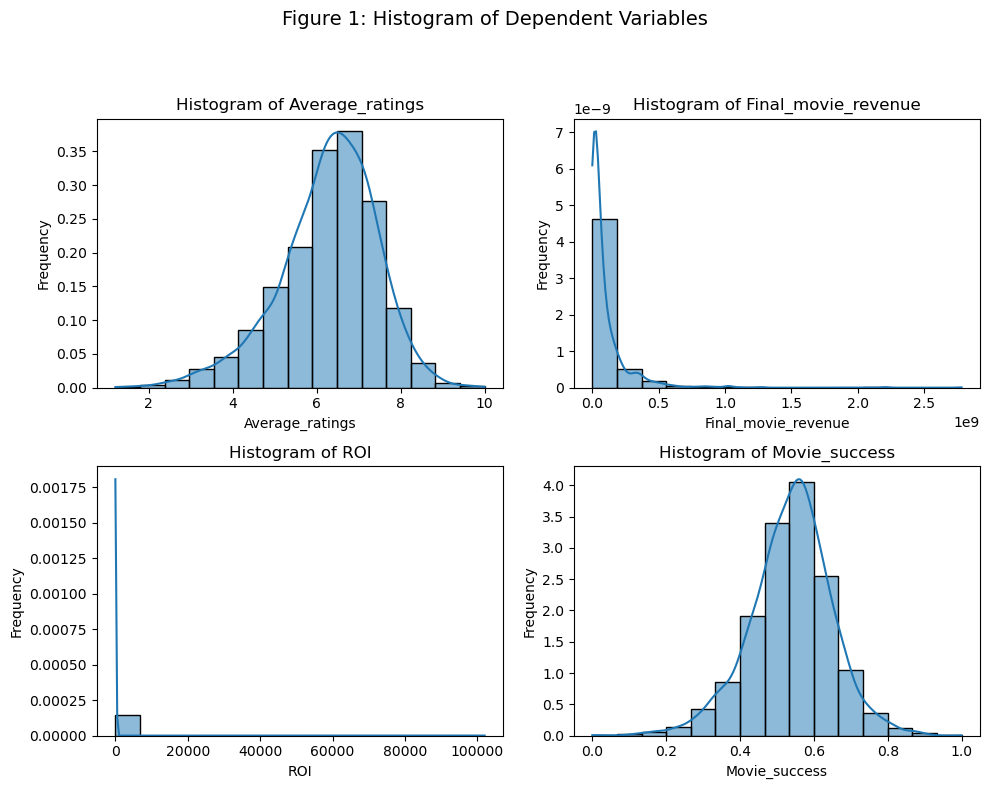

In [ ]:
eda.plot_histograms_combined(
    variables=["Average_ratings", "Final_movie_revenue", "ROI", "Movie_success"],
    title="Figure 1: Histogram of Dependent Variables",
    bins=15,
    layout=(2, 2)
)

As we can see in Figure 1, the histogram for *Average_ratings* and *Movie_success* is bell-shaped, indicating a **normal distribution** of movie ratings and success.

As for the distribution of *Final_movie_revenue* and *ROI* are highly skewed. In order to adresse that, we have to apply a log transformation to them.

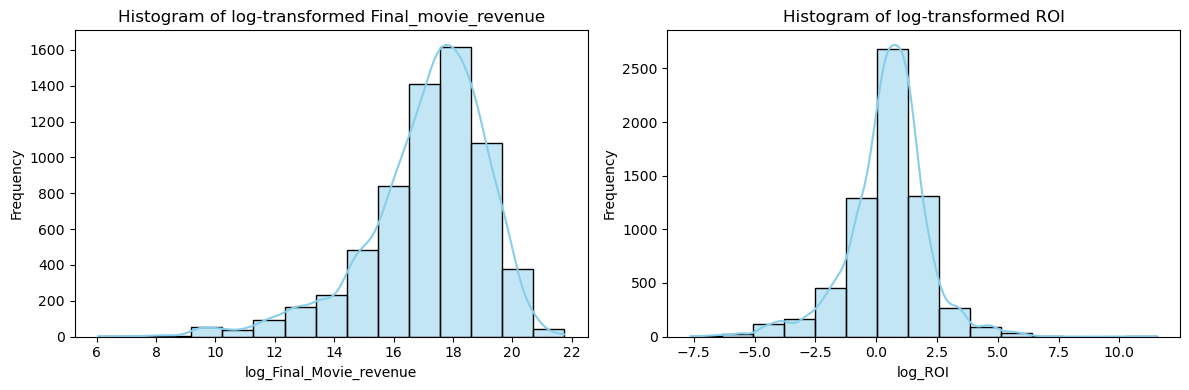

In [144]:
eda.dataframe = evaluation_utils.log_transform(eda.dataframe, ["Final_movie_revenue", "ROI"])
eda.plot_log_transformed_histograms()

Now we have successfully obtained a normal distribution for the *Final_Movie_revenue* and *ROI*. 

Let's now look at our independent variables.

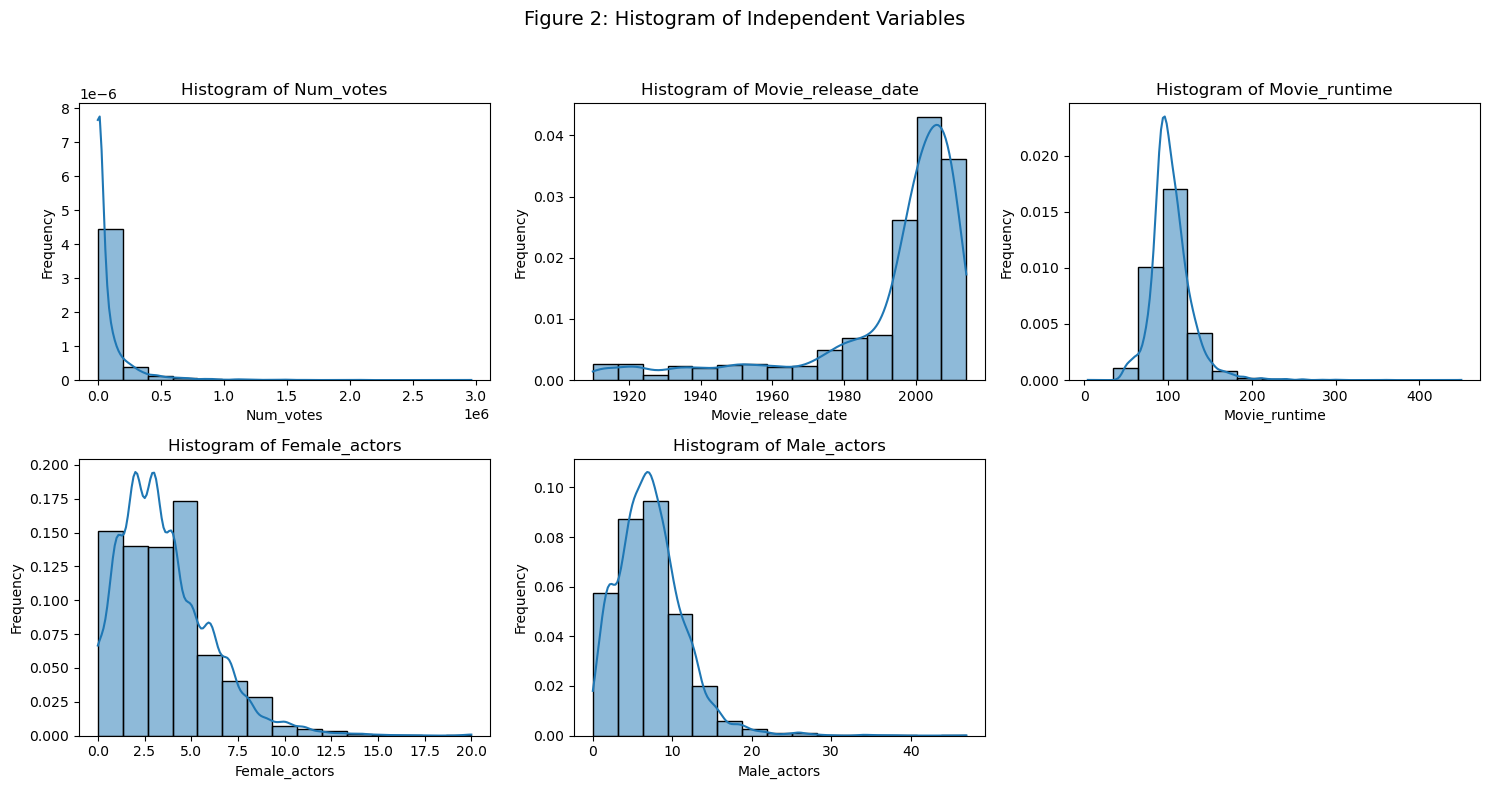

In [145]:
eda.plot_histograms_combined(
    variables=["Num_votes", "Movie_release_date", "Movie_runtime", "Female_actors", "Male_actors"],
    title="Figure 2: Histogram of Independent Variables",
    bins=15,
    layout=(2, 3)
)

The histogram for the *Movie_release_date* shows an increase in movie releases after the 1980s, with a sharp spike around the 2000s. This suggests that the number of movie releases accelerated significantly in the late 20th and early 21st centuries.

For the rest of the variables, we need to apply log transformation since they are skewed, being: *Num_votes*, *Movie_runtime*, *Female_actors* and *Male_actors*.

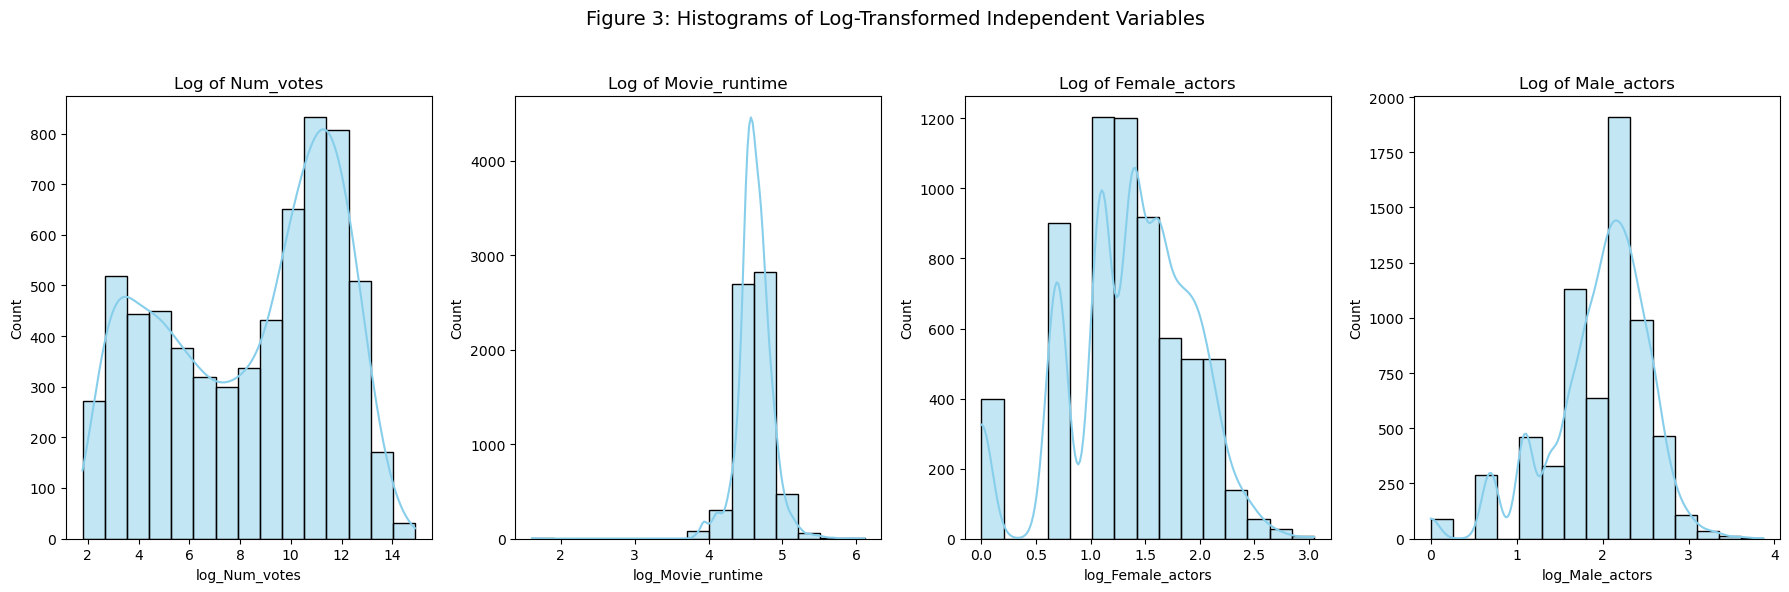

In [146]:
# Apply log transformation to skewed independent variables
eda.dataframe = evaluation_utils.log_transform(eda.dataframe, ["Num_votes", "Movie_runtime", "Female_actors", "Male_actors"])

eda.plot_log_transformed_independent_histograms()

Log of Num_votes: A bimodal distribution, with most movies receiving moderate votes and a smaller group of popular movies getting significantly more votes.

Log of Movie_runtime: Right-skewed, with most movies having runtimes between 50 to 150 minutes (from Figure 2), and few with very long runtimes.

Log of Female_actors: Slightly bimodal, with most movies having a small number of female actors, and a few with more.

Log of Male_actors: Similar to female actors, the distribution is skewed towards movies with fewer male actors, and only a few movies have a large number of male actors.

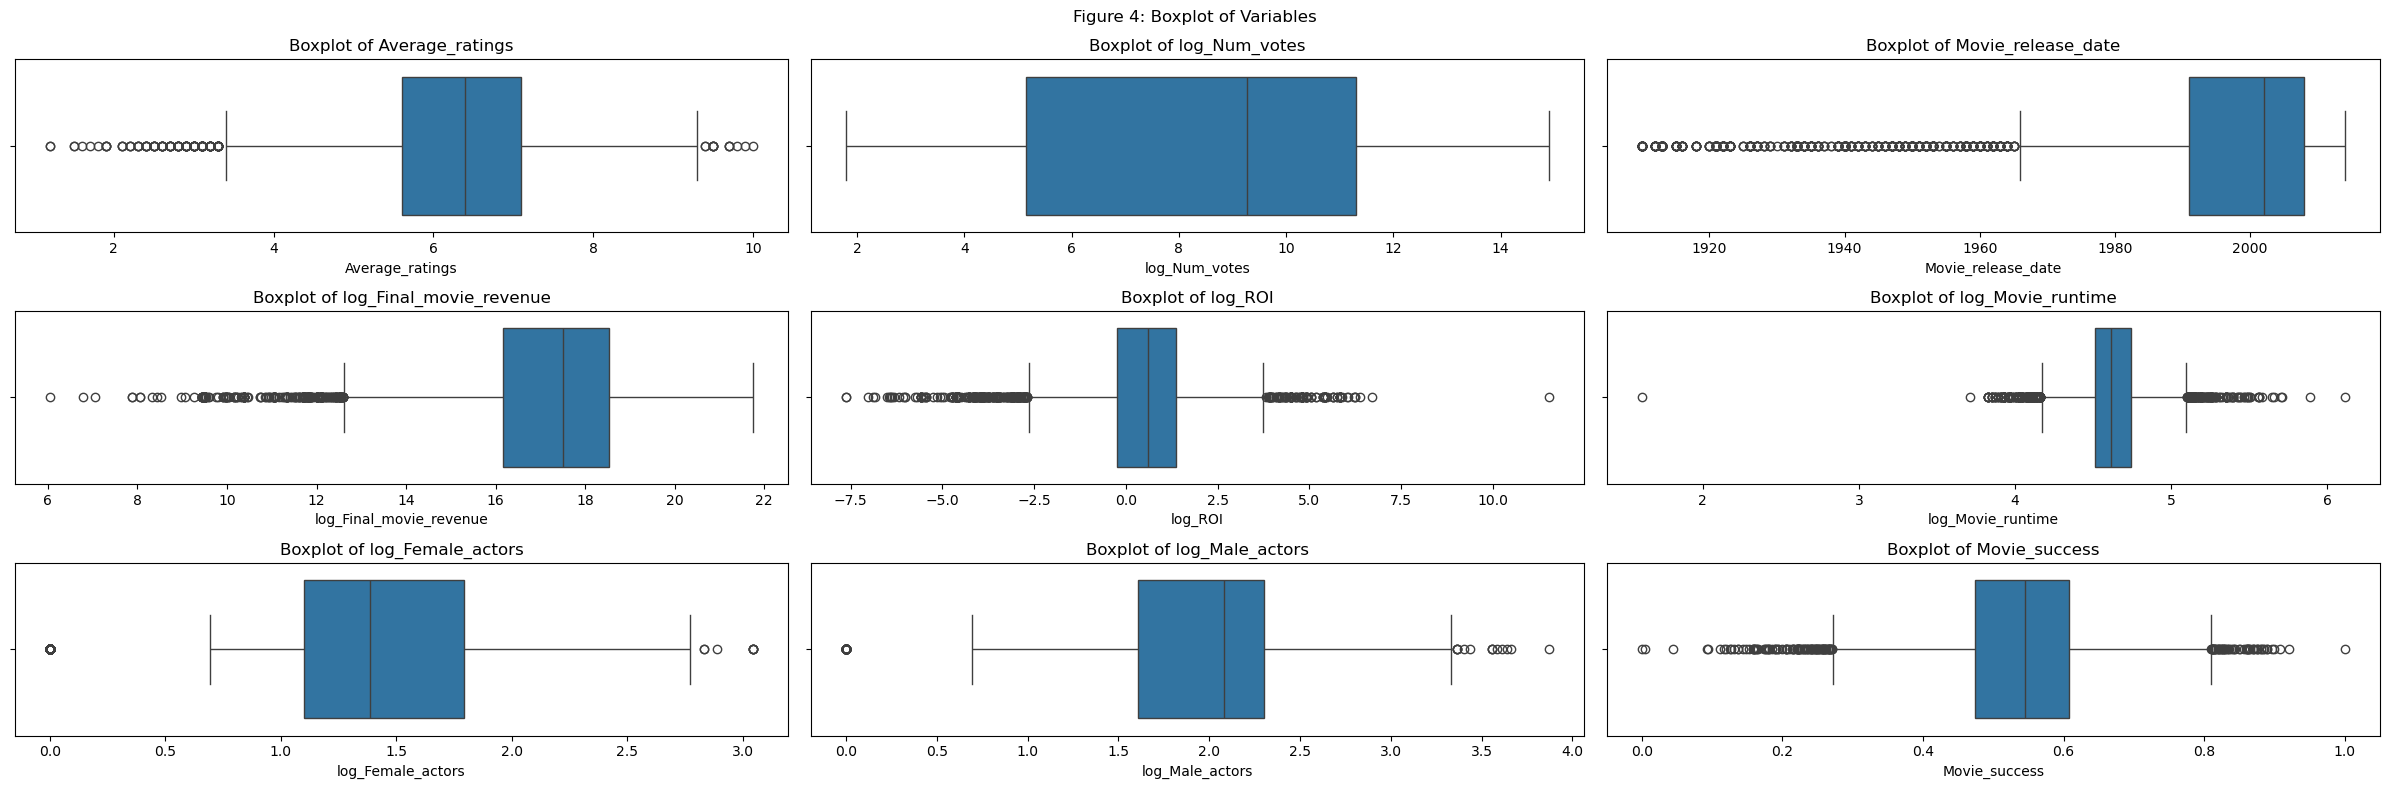

In [147]:
eda.numeric_columns = ["Average_ratings",
                   "log_Num_votes",
                   "Movie_release_date",
                   "log_Final_movie_revenue",
                   "log_ROI",
                   "log_Movie_runtime",
                   "log_Female_actors",
                   "log_Male_actors",
                   "Movie_success"]

eda.plot_boxplots()

We now have to focus on outliers and removing them for a more accurate modeling. From the boxplots, we chose the remove the outliers of the *Movie_box_office_revenue* and the *Minutes_runtime* variables. To do that, we use the **InterQuartile Range (IQR) method**, which identifies values that are significantly higher or lower than the majority of the data.

The *remove_outliers* function will calculate the IQR for each column specified and removes any rows with values outside the range:

$[Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}]$


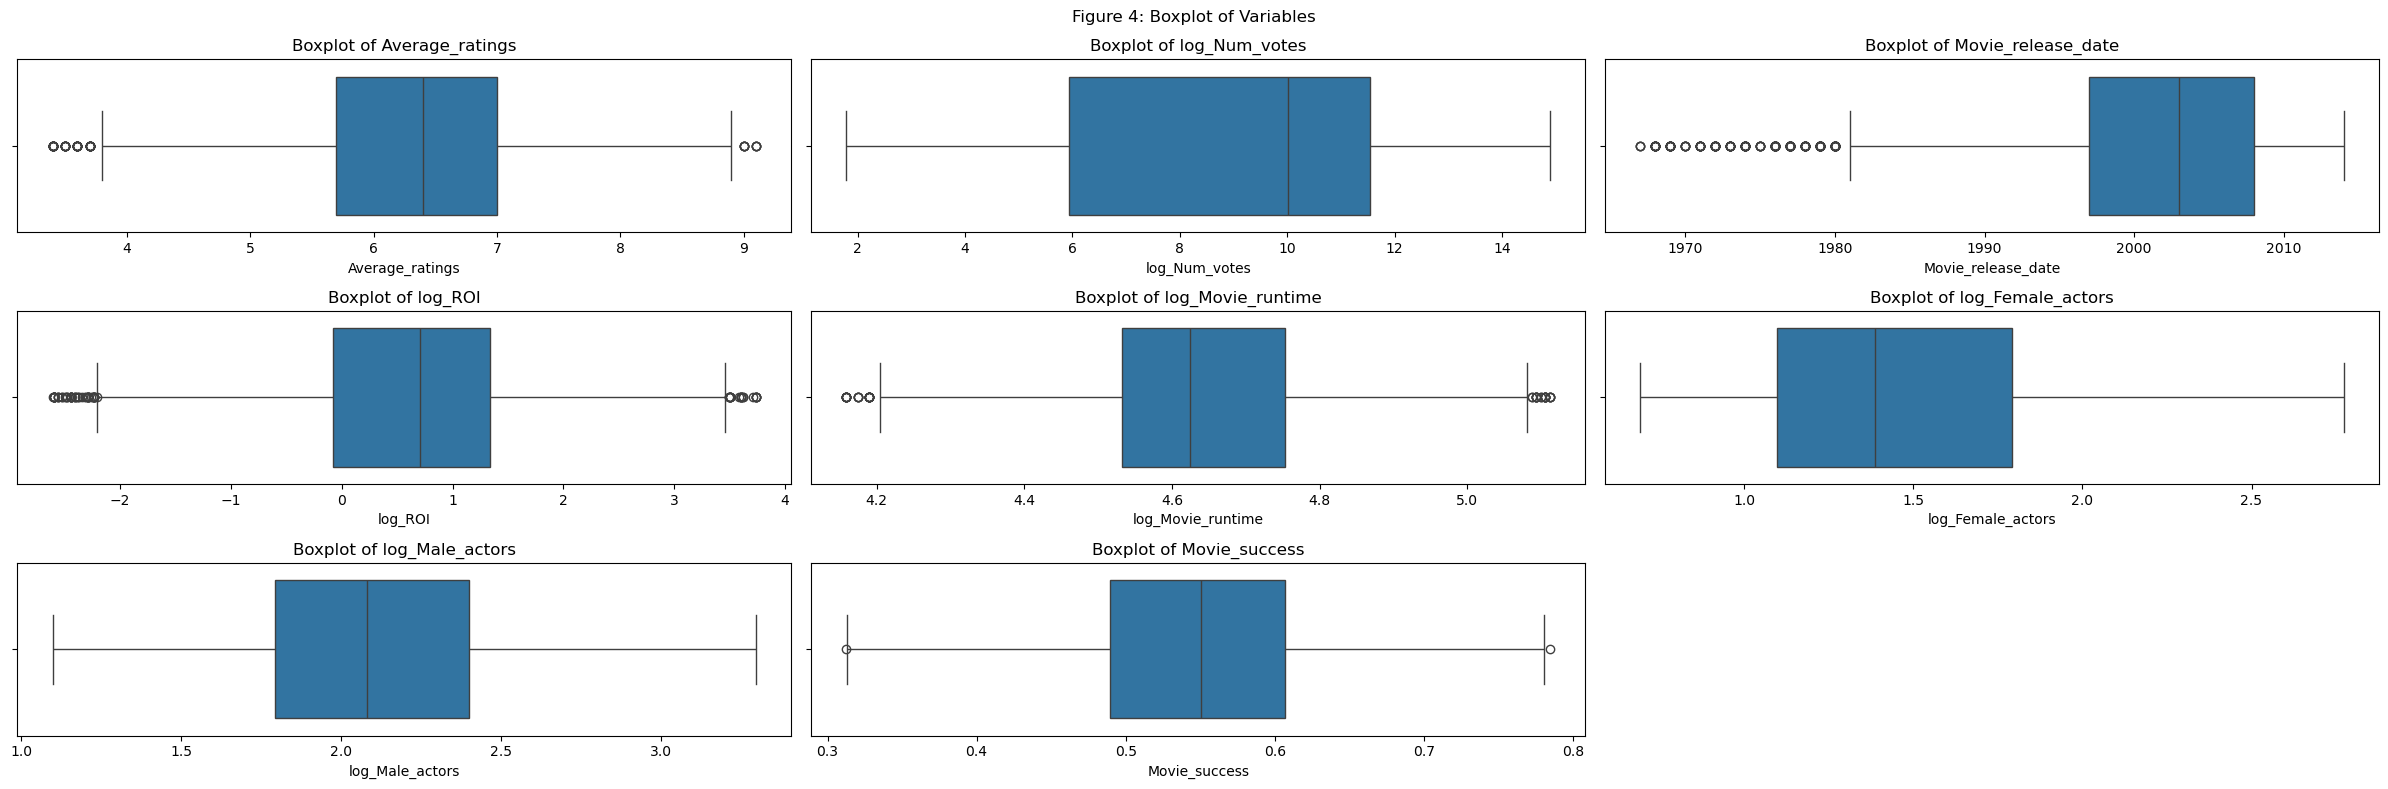

In [148]:
eda.numeric_columns = ["Average_ratings",
                   "log_Num_votes",
                   "Movie_release_date",
                   #"log_Final_movie_revenue",
                   "log_ROI",
                   "log_Movie_runtime",
                   "log_Female_actors",
                   "log_Male_actors",
                   "Movie_success"]

# Dataframe without outliers
eda.dataframe = data_utils.remove_outliers(eda.dataframe, eda.numeric_columns)

eda.plot_boxplots()

In [149]:
print(f"After removing the outliers and dropping the null values, we are left with {len(eda.dataframe):,} movies.")

After removing the outliers and dropping the null values, we are left with 4,597 movies.


##### 1.1.2 Bivariate Analysis of continuous variables

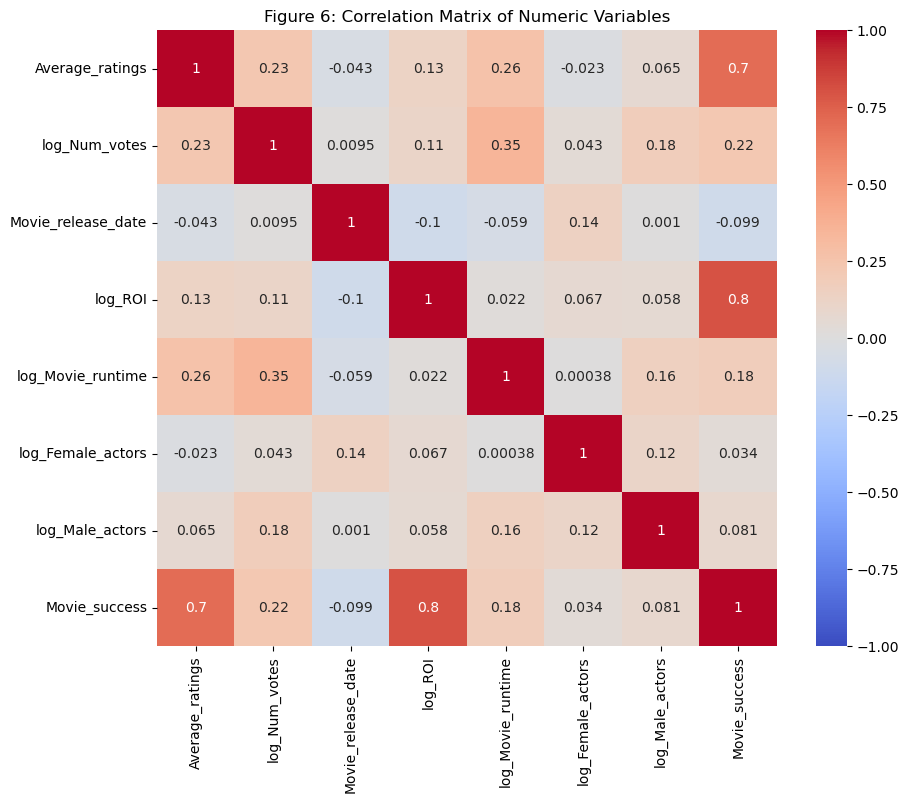

In [150]:
eda.plot_correlation_matrix()

The correlation matrix for the continuous variables in our dataset shows the following relationships:

•⁠  *log_⁠Female_actors* and *log_Male_actors*: The correlation coefficient is *0.11*, indicating a weak positive correlation. This suggests that movies with a higher number of female actors also tend to have a higher number of male actors. We note that this could indicate a general tendency for larger casts to include more actors of both genders.

•⁠  *log_⁠Final_movie_revenue* and *log_Male_actors*: The correlation coefficient is *0.27*, indicating a moderate positive correlation. This suggests that movies with more male actors might achieve higher box office earnings. 

•⁠  *log_Female_actors* and *Movie_release_date*: The correlation coefficient is *0.15*, indicating a weak positive correlation. This suggests that more recent movies tend to include a higher number of female actors. 

•⁠  *Movie_success* has a strong positive correlation with *log_ROI* (0.79) and A*verage_ratings* (0.72), which makes sense since it was calculated from them.

While gender composition affects the correlation, these findings highlight the need for deeper analysis (e.g., regression) to control for potential confounders and isolate the impact of gender on box office success.

#### 1.1.3 Analysis and encoding of categorical variables
Regression analysis with many categorical variables can quickly get complicated. Indeed using a boolean value for each category except one can cause us to have too many regressors. For variables like isAdult and Gender it is easy as there are only two possibilities. However, for Movie_genre, Movie_countries and Movie_languages we can quickly get into the hundreds. Here is how we plan on managing this:

##### 1.1.3.1 Analysis of the Movies' genres

We set a cutoff threshold of 1000. This means all genres with less than 1000 occurences will be discarded. 

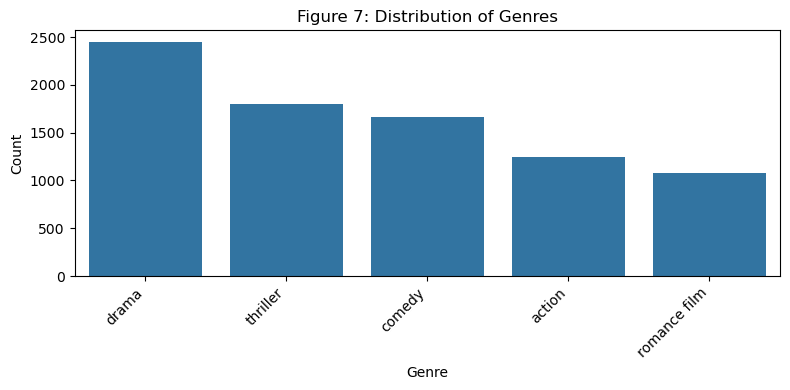

There are 5 genres with more that 1000 occurences.


In [151]:
filtered_genre_counts = eda.filter_and_count(column_name="Movie_genres", threshold=1000)

Let us check if this restricts our study to too few movies.

In [152]:
popular_genres = eda.analyze_popular_genres(filtered_genre_counts=filtered_genre_counts)

There are 4422 movies that belong to at least one of the 5 most popular genres. 
There were 4597 movies in the dataset before this operation, meaning we lost 3.81% of the movies.


We can drop the movies that have none of the most popular genres. We can also assume that the genres are ordered by relevance. This assumption was made after manually checking for 50 randomly sampled movies. It was true for all 50. We will thus keep for each movie, the first popular genre that appears.

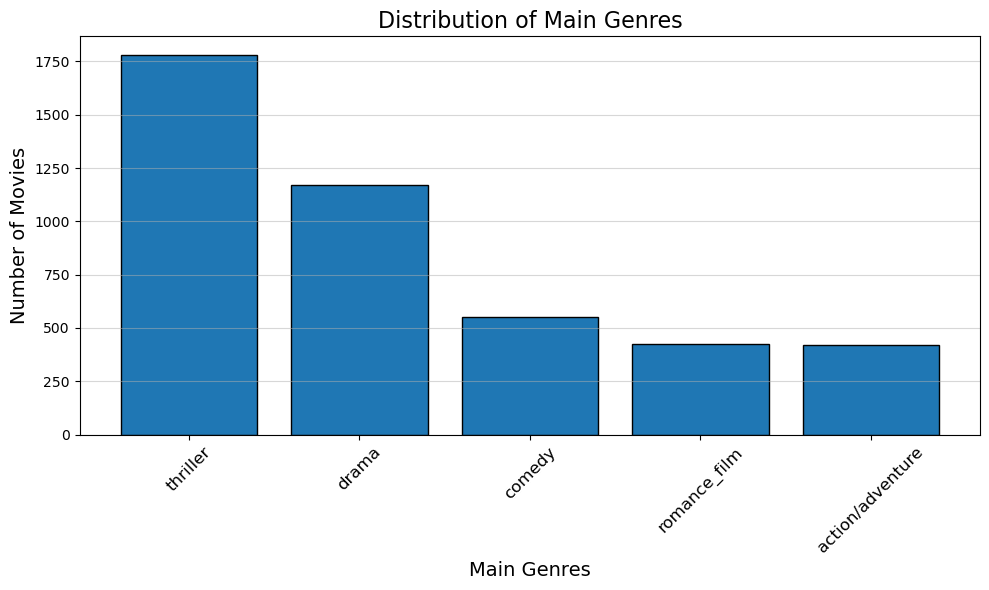

In [153]:
# Creating a new column named "Main_genre" that stores, for each movie, the first occurence of one of the popular genres
eda.get_main_genres(popular_genres=popular_genres)

We can now create the dummy variables for the "Main_genre" column using one-hot encoding.

In [154]:
eda.dataframe = pd.get_dummies(eda.dataframe, columns=["Main_genre"], drop_first=True) # Reference category is action/adventure
eda.dataframe.sample(5)

,tconst,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,...,log_Final_movie_revenue,log_ROI,log_Num_votes,log_Movie_runtime,log_Female_actors,log_Male_actors,Main_genre_comedy,Main_genre_drama,Main_genre_romance_film,Main_genre_thriller
18196,tt0339195,6.40,97,in & out,in & out,1,1986,nm0237015,NaN,1997,...,17.97,0.60,4.58,4.39,2.30,2.40,False,False,True,False
19729,tt0426931,7.40,112066,august rush,august rush,0,2007,nm0792202,"nm0145309,nm0366337,nm1554513",2007,...,17.99,0.96,11.63,4.74,1.61,2.48,False,True,False,False
24552,tt14571278,8.80,132,the lion king,the lion king,0,1997,nm0853380,nm0021249,1994,...,20.67,2.48,4.89,4.48,1.61,2.40,False,False,False,False
14740,tt0160395,6.10,184,an ideal husband,an ideal husband,0,1999,nm0142081,"nm0928492,nm0142081",1999,...,17.26,1.07,5.22,4.51,1.61,1.95,False,True,False,False
10111,tt0087928,6.70,140894,police academy,police academy,0,1984,nm0933505,"nm0411477,nm0698493,nm0933505,nm0556487",1984,...,18.21,2.89,11.86,4.57,1.39,2.40,True,False,False,False


##### 1.1.3.2 Analysis of the Movies' languages

We will plot the top 5 languages by number of occurences:

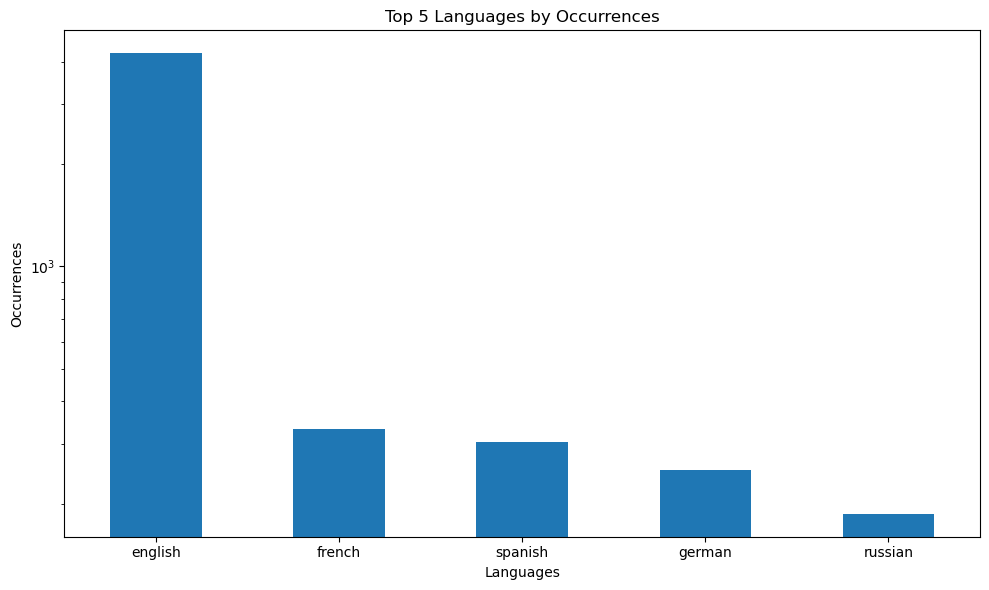

In [155]:
eda.analyze_languages()

We have an unbalanced dataset with English being much more prominent than other languages.

Categorizing movies into two groups: 
- those available exclusively in English, 
- those available in other languages (which may include English alongside another language).

This will be done through the creation of the boolean "Is_not_only_english" which is True when the movie is available in another language.

In [156]:
eda.categorize_languages()

There are 1339 movies that are available in other languages and 3083 movies that are only available in English.


##### 1.1.3.2 Analysis of the Movies' countries

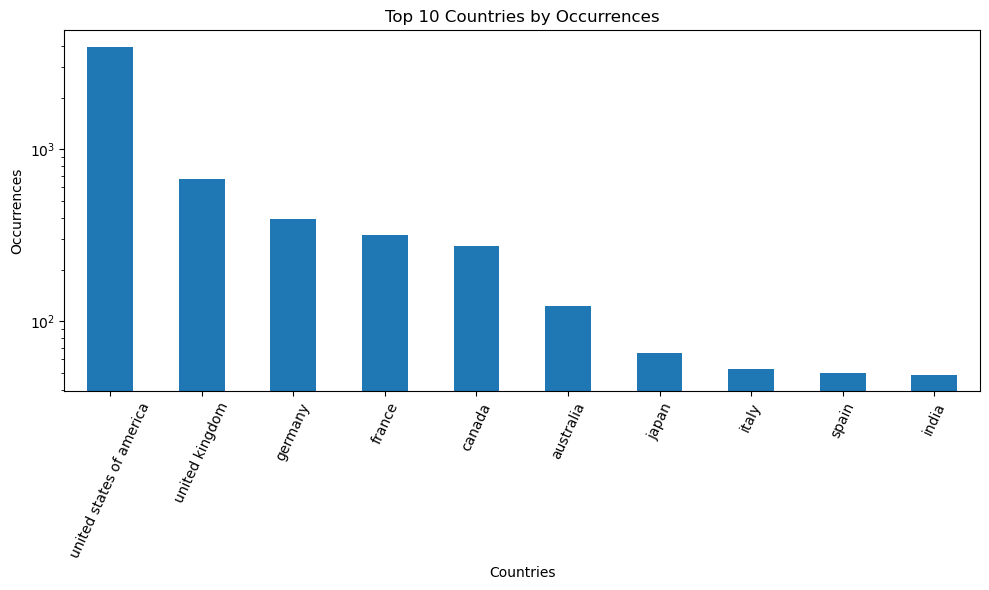

In [157]:
eda.analyze_countries()

We have a very similar situation to the languages. The United States of America have a much more prominent number of movies. We will thus proceed like previously by categorizing the movies into two groups:
- USA movies 
- Movies from other countries 

This will be done through the creation of the boolean "Is_USA_movie" which is True when the movie is from the USA.

In [158]:
count_usa_movies = (eda.dataframe["Movie_countries"] == "united states of america").sum()
count_other_countries_movie = len(eda.dataframe) - count_usa_movies 
print(f"There are {count_usa_movies} USA movies and {count_other_countries_movie} movies from other countries.")

There are 2804 USA movies and 1600 movies from other countries.


In [159]:
eda.categorize_countries()

There are 2804 USA movies and 1600 movies from other countries.


##### 1.1.3.2 Analysis of the Movies' production companies

There are 2844 unique production companies.


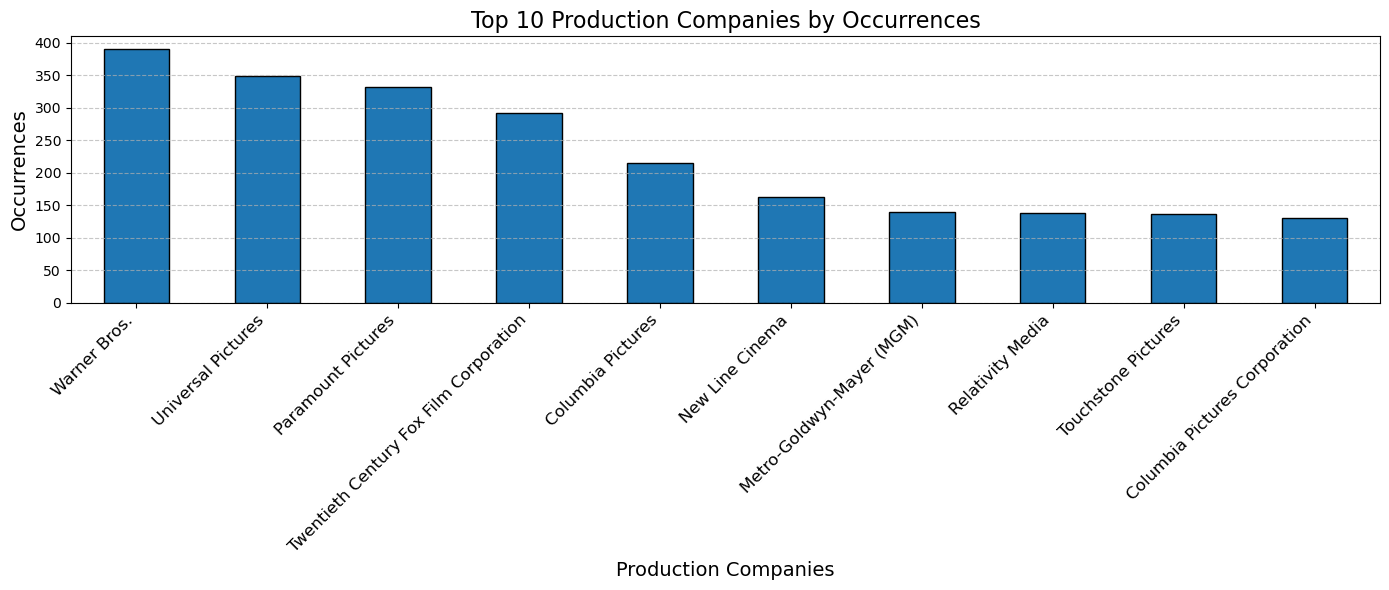

In [160]:
filtered_production_count = eda.analyze_production_companies()

In [ ]:
prod_companies = pd.read_csv("data/Extra CSV/production_companies.csv")

box_office = eda.merge_production_data(filtered_production_count, prod_companies)


We inspect the company names and we saw that there are Columbia Pictures and Columbia Pictures Corporation. There are two names for the same company. 
We apply unify_columbia_revenue to attribute the same revenue for them. 

In [163]:
eda.unify_columbia_revenue(box_office_df=box_office)


In [ ]:
box_office["Total Worldwide Box Office"] = box_office["Total Worldwide Box Office"].replace(
    {"\$": "", ",": ""}, regex=True).astype(float)

def calculate_box_office(companies_list):
   if not companies_list:
        return 0  
   return box_office.loc[box_office["Company Name"].isin(companies_list), "Total Worldwide Box Office"].sum()

eda.dataframe["Box_office_companies"] = eda.dataframe["Production_companies_cleaned"].apply(calculate_box_office)
eda.filter_movies_with_box_office(box_office_column="Box_office_companies")

After removing rows without Box Office revenue, 4304 movies remain out of 4304.


## je regle ca asap juste la ca me pete les couilles 

In [165]:
print(eda.dataframe.columns)


Index(['tconst', 'Average_ratings', 'Num_votes', 'Primary_title',
       'Original_title', 'Is_adult', 'Start_year', 'Directors', 'Writers',
       'Movie_release_date', 'Movie_languages', 'Movie_countries',
       'Movie_genres', 'Cast', 'Female_actors', 'Male_actors',
       'Female_actor_percentage', 'Movie_runtime', 'Plot Summaries',
       'Popularity', 'Production_companies', 'production_countries',
       'Domestic_gross', 'Movie_budget', 'Final_movie_revenue', 'ROI',
       'Normalized_Rating', 'Log_ROI', 'Movie_success',
       'log_Final_movie_revenue', 'log_ROI', 'log_Num_votes',
       'log_Movie_runtime', 'log_Female_actors', 'log_Male_actors',
       'Main_genre_comedy', 'Main_genre_drama', 'Main_genre_romance_film',
       'Main_genre_thriller', 'Is_not_only_english', 'Is_USA_movie',
       'Production_companies_cleaned', 'Box_office_companies'],
      dtype='object')


### 1.2 Identifying Potential Confounders
In order to not have bias in our study, it is essential we add the confounders. This means that we have to identify the variables that have an impact on both treatment and outcome, here being the actor gender and the final box office revenue respectivly. The confounders are: 
-  ⁠Movie_genre
-  ⁠Movie_countries
- ⁠Movie_languages
- Num_votes

### 1.3 Linear Regression


In [166]:
final_df_regression = eda.dataframe.copy()

In [167]:
print(final_df_regression.columns)

Index(['tconst', 'Average_ratings', 'Num_votes', 'Primary_title',
       'Original_title', 'Is_adult', 'Start_year', 'Directors', 'Writers',
       'Movie_release_date', 'Movie_languages', 'Movie_countries',
       'Movie_genres', 'Cast', 'Female_actors', 'Male_actors',
       'Female_actor_percentage', 'Movie_runtime', 'Plot Summaries',
       'Popularity', 'Production_companies', 'production_countries',
       'Domestic_gross', 'Movie_budget', 'Final_movie_revenue', 'ROI',
       'Normalized_Rating', 'Log_ROI', 'Movie_success',
       'log_Final_movie_revenue', 'log_ROI', 'log_Num_votes',
       'log_Movie_runtime', 'log_Female_actors', 'log_Male_actors',
       'Main_genre_comedy', 'Main_genre_drama', 'Main_genre_romance_film',
       'Main_genre_thriller', 'Is_not_only_english', 'Is_USA_movie',
       'Production_companies_cleaned', 'Box_office_companies'],
      dtype='object')


In [168]:
indep_vars = ["log_Female_actors", "log_Male_actors", "log_Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie",  "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_romance_film", "Start_year",
                   "Box_office_companies", "log_Num_votes"]

dep_vars = "Log_ROI"

X = final_df_regression[indep_vars]
y = final_df_regression[dep_vars]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled_wconst = sm.add_constant(X_scaled)

In [169]:
# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# Display VIF values
print(vif_data)

                    Feature  VIF
0         log_Female_actors 1.10
1           log_Male_actors 1.16
2         log_Movie_runtime 1.27
3       Is_not_only_english 1.08
4              Is_USA_movie 1.10
5          Main_genre_drama 2.59
6       Main_genre_thriller 2.78
7         Main_genre_comedy 1.86
8   Main_genre_romance_film 1.75
9                Start_year 1.03
10     Box_office_companies 1.06
11            log_Num_votes 1.22


We can see that all VIF values are far below 5 indicating multicollinearity should not be an issue.

In [170]:
model = sm.OLS(y, X_scaled_wconst).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Log_ROI   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     17.09
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           2.48e-36
Time:                        19:46:09   Log-Likelihood:                 6171.9
No. Observations:                4304   AIC:                        -1.232e+04
Df Residuals:                    4291   BIC:                        -1.224e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [171]:
indep_vars = ["log_Female_actors", "log_Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie",  "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_romance_film", "Start_year",
                   "Box_office_companies", "Log_ROI"]

dep_vars = "Normalized_Rating"

X = final_df_regression[indep_vars]
y = final_df_regression[dep_vars]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled_wconst = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled_wconst).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Normalized_Rating   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     48.13
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.94e-108
Time:                        19:46:09   Log-Likelihood:                 3967.2
No. Observations:                4304   AIC:                            -7908.
Df Residuals:                    4291   BIC:                            -7826.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [172]:
# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# Display VIF values
print(vif_data)

                    Feature  VIF
0         log_Female_actors 1.10
1           log_Male_actors 1.16
2             Movie_runtime 1.12
3       Is_not_only_english 1.10
4              Is_USA_movie 1.11
5          Main_genre_drama 2.57
6       Main_genre_thriller 2.77
7         Main_genre_comedy 1.86
8   Main_genre_romance_film 1.75
9                Start_year 1.02
10     Box_office_companies 1.07
11                  Log_ROI 1.04


We can see that all VIF values are far below 5 indicating multicollinearity should not be an issue.

### 4. How does it compare to streaming platforms?

In this section, we want to expand our study by analyzing data from various streaming platforms. We focus on the movies of Netflix, Amazon Prime, Disney+, and Hulu. To achieve this, we created a dataset by merging data from multiple sources found on Kaggle.


This dataset structure enables comprehensive analysis across various dimensions such as gender repartition in the cast, the ratings and description. Using these columns, we can investigate how streaming platform movies differ in content and ratings compared to traditional box office movies.



In [2]:
streaming_df = get_streaming_dataframe()

In [3]:
streaming_df.head()

,Show_id,Type,Movie_name,Director,Cast,Movie_countries,Date_added,Movie_release_date,Age_ratings,Movie_runtime,Movie_genres,Description,Platform,Male_actors,Female_actors,Average_ratings,Num_votes,Is_Adult,Movie_languages
1,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125.0,Drama & Emotion,"On a photo shoot in Ghana, an American model s...",Netflix,2,2,7.0,859,1,"English, French, German"
2,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104.0,"Drama & Emotion, Comedy & Light-Hearted",A woman adjusting to life after a loss contend...,Netflix,5,6,6.4,15653,0,English
3,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127.0,Drama & Emotion,After most of her family is murdered in a terr...,Netflix,3,6,5.6,1622,1,"German, Czech"
8,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166.0,"Drama & Emotion, Comedy & Light-Hearted",When the father of the man she loves insists t...,Netflix,0,1,6.5,4085,0,Hindi
9,s28,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,"September 20, 2021",2010,PG-13,103.0,Comedy & Light-Hearted,Mourning the loss of their beloved junior high...,Netflix,5,6,6.0,286335,0,English


In [4]:
streaming_df.drop_duplicates(inplace=True)


a. <u>Numerical Analysis</u>: 

In [5]:
eda_streaming = EDA(streaming_df.copy())


In [6]:
pd.options.display.float_format = "{:,.2f}".format

# Filtrer uniquement les colonnes qui existent dans la dataframe
existing_numeric_columns = [col for col in eda_streaming.numeric_columns if col in eda_streaming.dataframe.columns]

# Convert columns to numeric for existing columns and drop rows with missing data
eda_streaming.dataframe[existing_numeric_columns] = eda_streaming.dataframe[existing_numeric_columns].apply(pd.to_numeric, errors="coerce")
eda_streaming.dataframe.dropna(subset=existing_numeric_columns, inplace=True)

# Summary statistics
summary_table = eda_streaming.summary_bis()

summary_table


,Min,Max,Mean,SD,Median
Average_ratings,1.50,10.00,6.31,1.20,6.40
Num_votes,5.00,"2,612,159.00","42,414.68","135,616.58","2,596.00"
Movie_release_date,"1,928.00","2,021.00","2,011.11",12.13,"2,016.00"
Movie_runtime,4.00,312.00,103.19,27.68,101.00
Female_actors,0.00,27.00,3.23,2.23,3.00
Male_actors,0.00,35.00,4.06,2.59,4.00


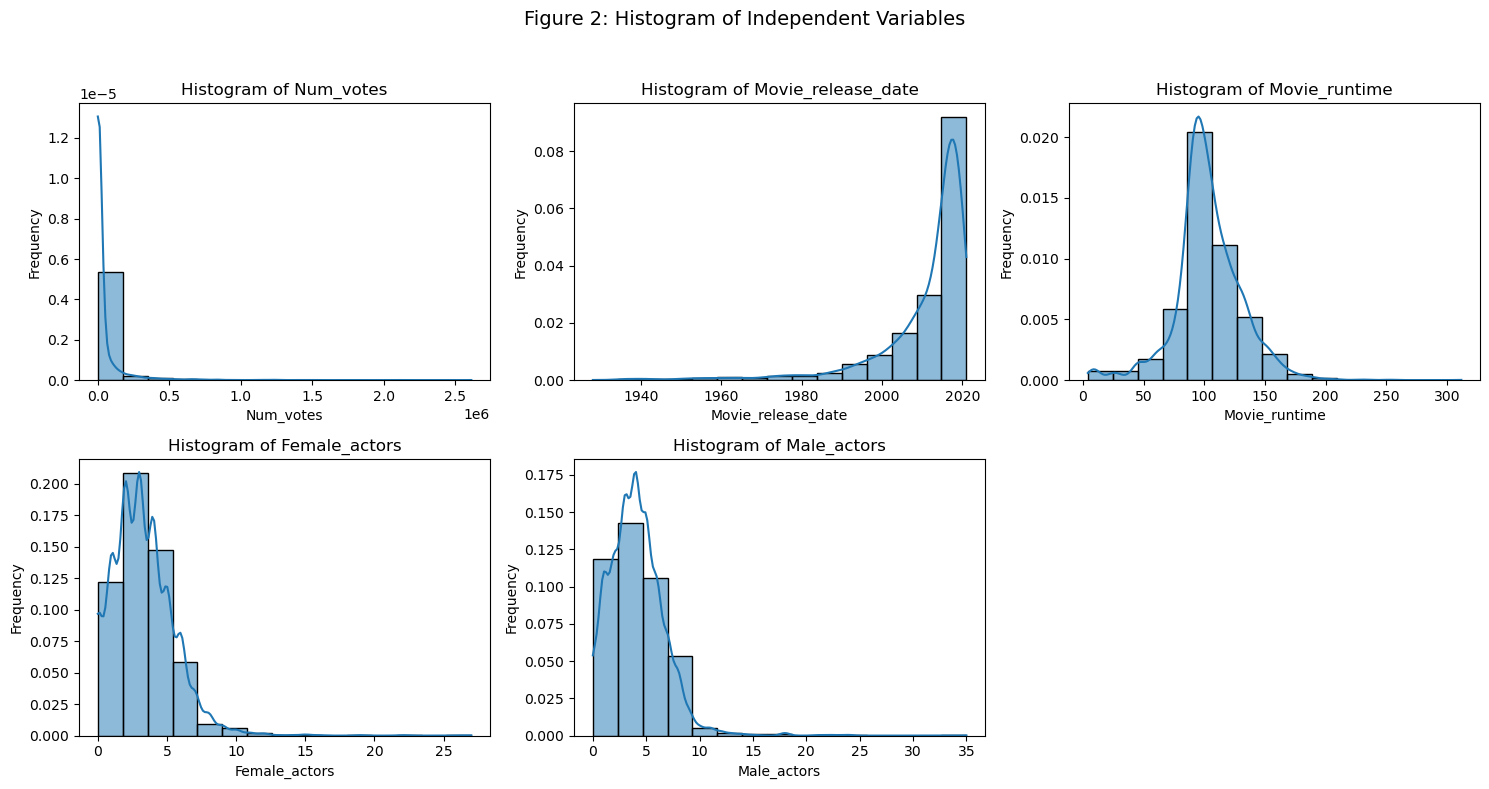

In [7]:
eda_streaming.plot_histograms_combined(
    variables=["Num_votes", "Movie_release_date", "Movie_runtime", "Female_actors", "Male_actors"],
    title="Figure 2: Histogram of Independent Variables",
    bins=15,
    layout=(2, 3)
)

Release_year : The majority of movies in the dataset are very recent with an increase after the year 2000. This distribution seems to be logical beause streaming platform really took place recently.

Movie_runtime: The duration of most movies is between 90 and 120 minutes, which is typical for films.

Female_count and male_count: We can see that the number of men is greater than women but this difference is lower than for CMU/IMDB movies.



## PEUT ETRE CHANGER LE SCALE DE NUMVOTES

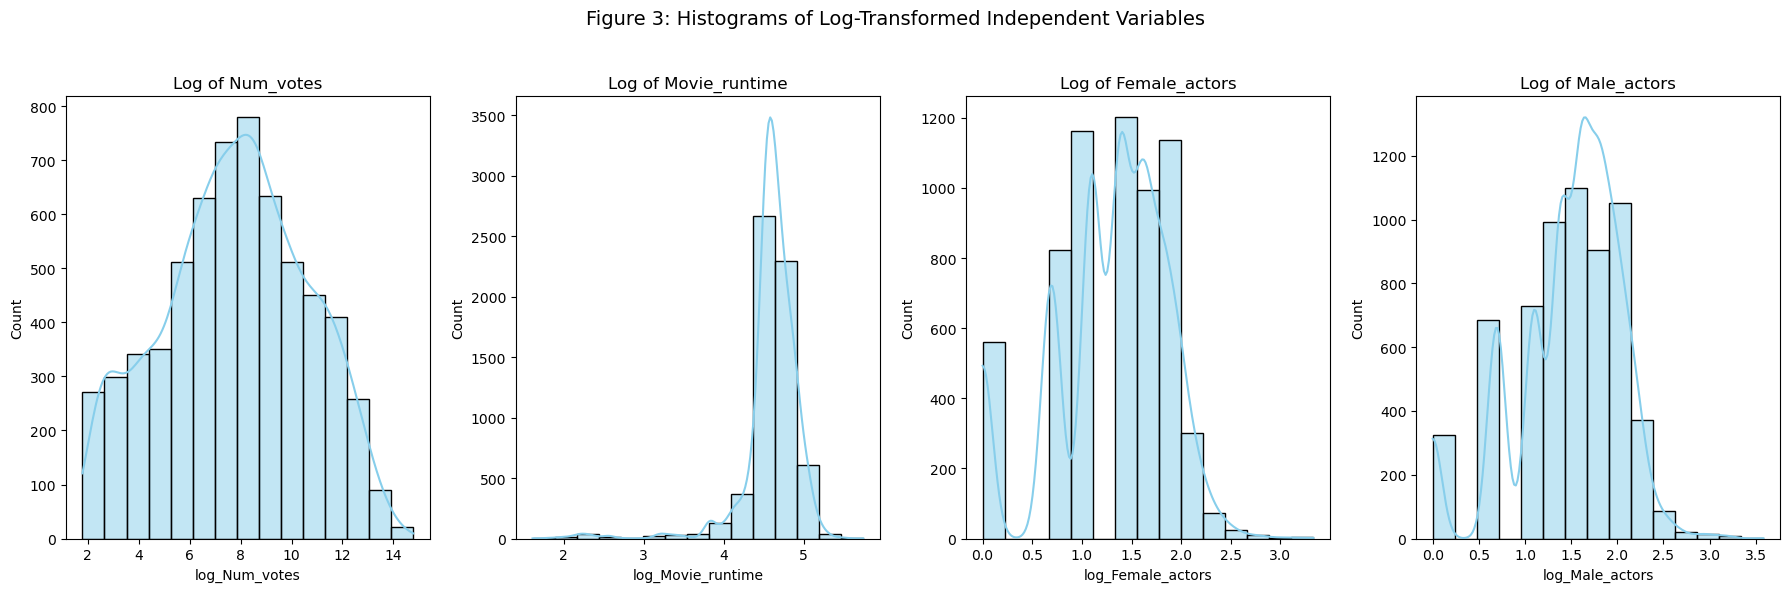

In [8]:
# Apply log transformation to skewed independent variables
eda_streaming.dataframe = evaluation_utils.log_transform(eda_streaming.dataframe, ["Num_votes", "Movie_runtime", "Female_actors", "Male_actors"])

eda_streaming.plot_log_transformed_independent_histograms()

Log_Num_Votes : The histogram shows a near symmetric distribution of log transformed movie votes resembling a normal distribution. Most movies have log-votes between 6 and 10.

Log_Movie_runtime: Most movies have a log runtime between 4 and 5, with the distribution slightly skewed to the right.

Log_Male_actors and log_female_actors : The log of female actors is slightly lower than the log of male actors. 

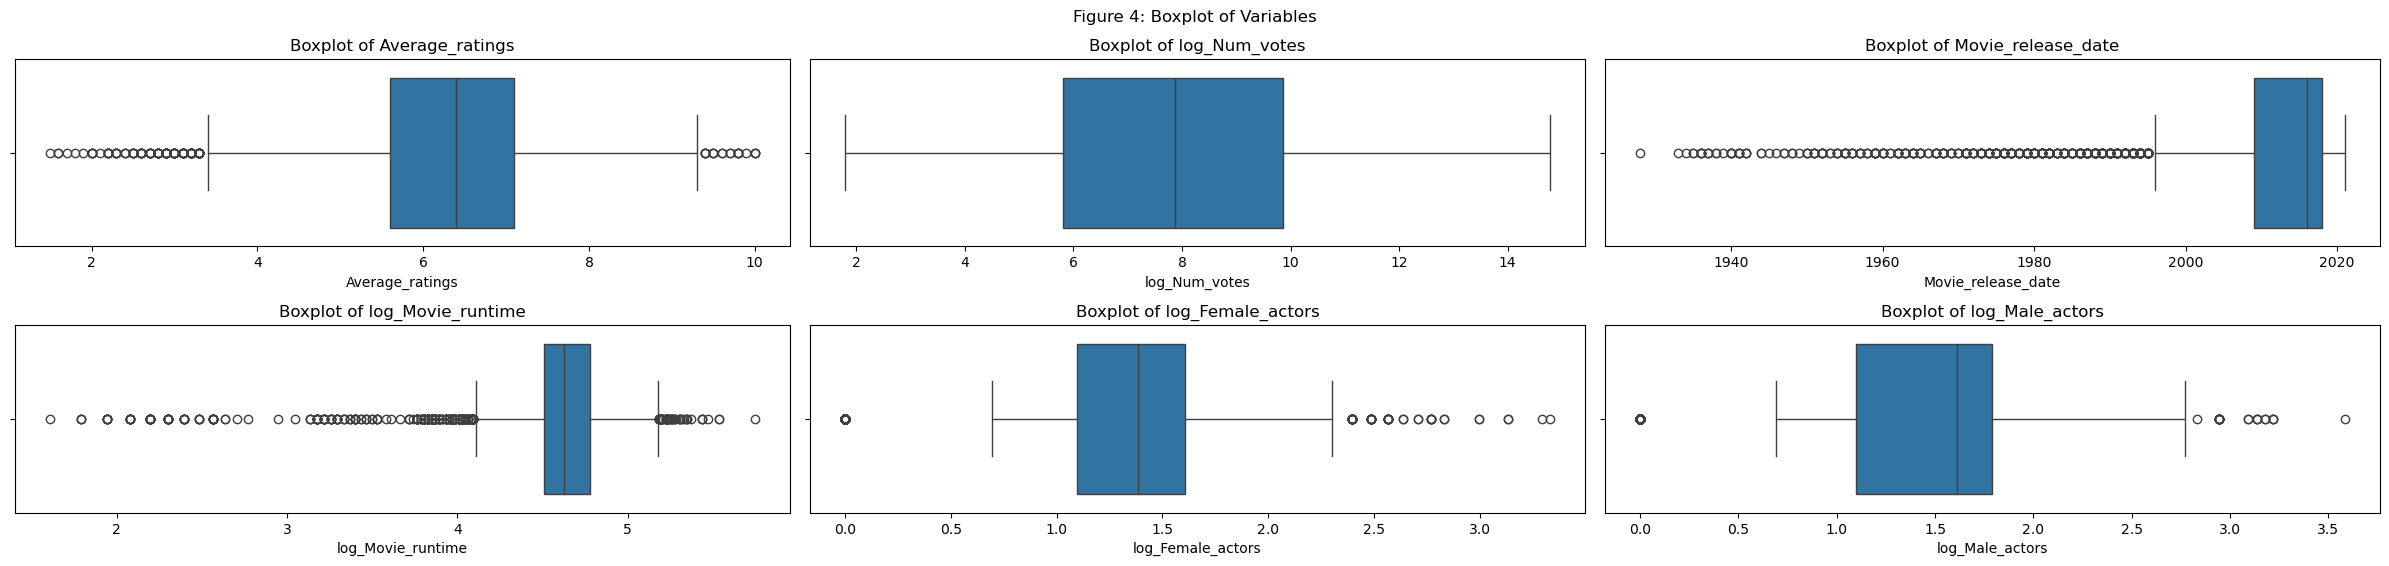

In [10]:
eda_streaming.numeric_columns = ["Average_ratings",
                   "log_Num_votes",
                   "Movie_release_date",
                   #"log_Final_movie_revenue",
                   #"log_ROI",   # je crois juste lui je le teje 
                   "log_Movie_runtime",
                   "log_Female_actors",
                   "log_Male_actors",
                   #"Movie_success"
                   ]

eda_streaming.plot_boxplots()

As we did in the previous part, we now have to focus on outliers and removing them for a more accurate modeling.

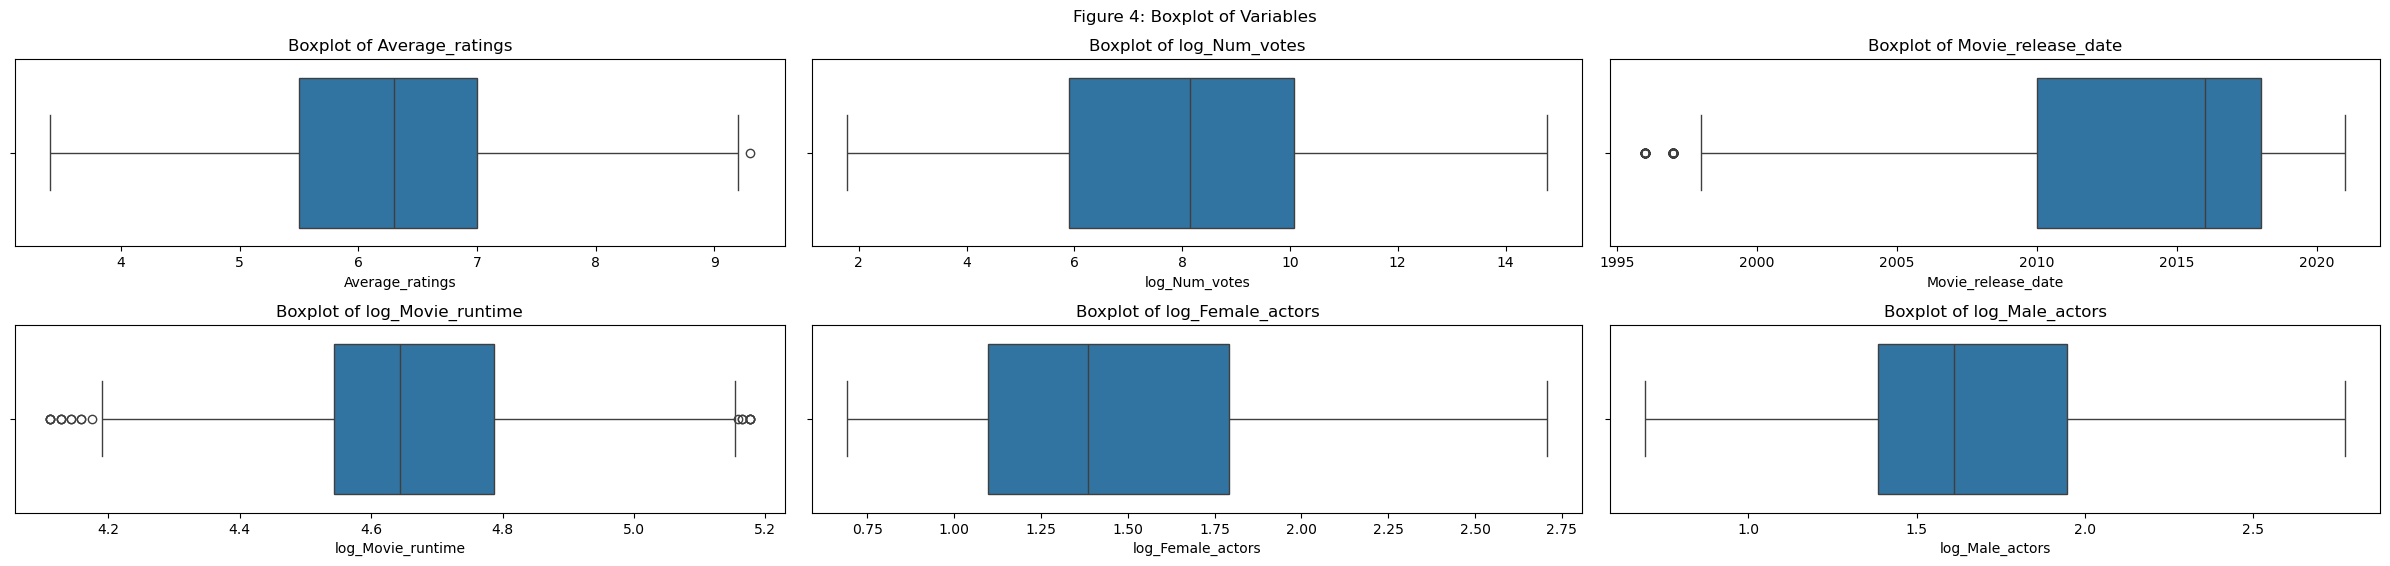

In [11]:

eda_streaming.dataframe = data_utils.remove_outliers(eda_streaming.dataframe, eda_streaming.numeric_columns)

eda_streaming.plot_boxplots()

In [13]:
print(f"After removing the outliers and dropping the null values, we are left with {len(eda_streaming.dataframe):,} movies.")

After removing the outliers and dropping the null values, we are left with 4,651 movies.


##### 4.1.2 Bivariate Analysis of continuous variables

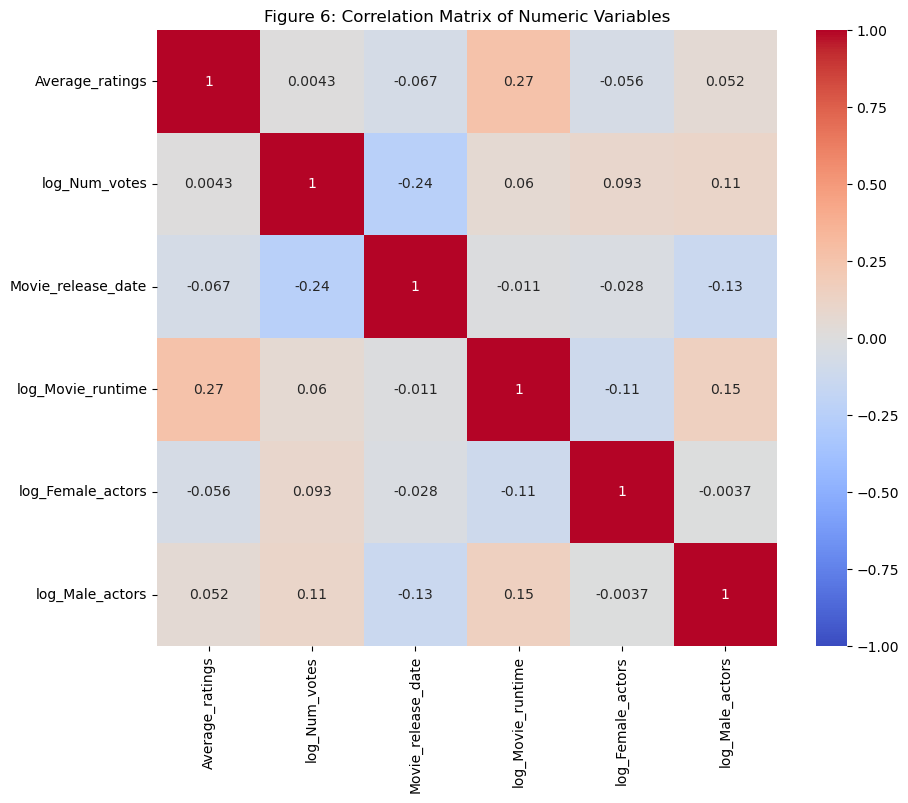

In [14]:
eda_streaming.plot_correlation_matrix()

The number of votes and gender composition (especially the number of male actors) seem to influence movie duration. It suggests that popularity and cast composition could impact movie production characteristics.
Weak correlations between movie duration and other variables indicate that duration might not strongly determine popularity based on votes.
This correlation matrix suggests further analysis like regression that could help separate and clarify the effects of gender and duration on popularity.

#### 4.1.3 Analysis and encoding of categorical variables
Regression analysis with many categorical variables can quickly get complicated. Indeed using a boolean value for each category except one can cause us to have too many regressors. For variables like isAdult and Gender it is easy as there are only two possibilities. However, for Movie_genre, Movie_countries and Movie_languages we can quickly get into the hundreds. Here is how we plan on managing this:

##### 4.1.3.1 Analysis of the Movies' genres

We set a cutoff threshold of 500. This means all genres with less than 500 occurences will be discarded. 

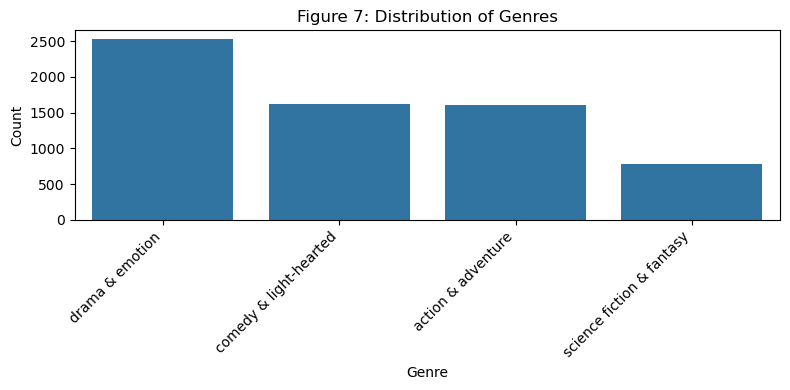

There are 4 genres with more that 500 occurences.


In [15]:
filtered_genre_counts = eda_streaming.filter_and_count(column_name="Movie_genres", threshold=500)

Let us check if this restricts our study to too few movies.

In [16]:
popular_genres = eda_streaming.analyze_popular_genres(filtered_genre_counts=filtered_genre_counts)

There are 4455 movies that belong to at least one of the 4 most popular genres. 
There were 4651 movies in the dataset before this operation, meaning we lost 4.21% of the movies.


We choose to only keep only the movies xhich have at more 2 genres and create dummies with all other combinations.

In [ ]:
eda_streaming.dataframe = eda_streaming.dataframe[eda_streaming.dataframe["Movie_genres"].apply(lambda x: len(x.split(",")) <= 2)]

Movie_genres
Drama & Emotion                                      1244
Drama & Emotion, Comedy & Light-Hearted               688
Comedy & Light-Hearted                                564
Drama & Emotion, Action & Adventure                   467
Action & Adventure                                    463
Action & Adventure, Science Fiction & Fantasy         389
Comedy & Light-Hearted, Action & Adventure            205
Science Fiction & Fantasy                             198
Comedy & Light-Hearted, Science Fiction & Fantasy      86
Drama & Emotion, Science Fiction & Fantasy             61
Name: count, dtype: int64


In [19]:
eda_streaming.dataframe = pd.get_dummies(eda_streaming.dataframe, columns=["Movie_genres"], drop_first=True) 
eda_streaming.dataframe.sample(5)

,Show_id,Type,Movie_name,Director,Cast,Movie_countries,Date_added,Movie_release_date,Age_ratings,Movie_runtime,...,log_Male_actors,"Movie_genres_Action & Adventure, Science Fiction & Fantasy",Movie_genres_Comedy & Light-Hearted,"Movie_genres_Comedy & Light-Hearted, Action & Adventure","Movie_genres_Comedy & Light-Hearted, Science Fiction & Fantasy",Movie_genres_Drama & Emotion,"Movie_genres_Drama & Emotion, Action & Adventure","Movie_genres_Drama & Emotion, Comedy & Light-Hearted","Movie_genres_Drama & Emotion, Science Fiction & Fantasy",Movie_genres_Science Fiction & Fantasy
1636,s2883,Movie,The Arbitration,Niyi Akinmolayan,"Adesua Etomi, O.C. Ukeje, Ireti Doyle, Sola Fo...",Nigeria,"February 26, 2020",2016,TV-MA,101.00,...,0.69,False,False,False,False,True,False,False,False,False
4393,s7666,Movie,One Night Stand,Jasmine D'Souza,"Tanuj Virwani, Sunny Leone, Narendra Jetley, A...",India,"October 15, 2017",2016,TV-MA,93.00,...,1.79,False,False,False,False,True,False,False,False,False
1976,s3488,Movie,The Grandmaster,Wong Kar Wai,"Tony Leung Chiu-wai, Zhang Ziyi, Chang Chen, X...","Hong Kong, China","September 26, 2019",2013,PG-13,108.00,...,1.95,False,False,False,False,False,True,False,False,False
1634,s2879,Movie,Couple of Days,Tolu Awobiyi,"Lilian Esoro, Ademola Adedoyin, Enyima Nwigwe,...",Nigeria,"February 26, 2020",2016,TV-14,103.00,...,1.39,False,False,False,False,True,False,False,False,False
9951,s455,Movie,Incredibles 2,Brad Bird,"Craig Nelson, Holly Hunter, Sarah Vowell, Huck...",United States,"July 31, 2020",2018,PG,118.00,...,1.39,False,False,False,False,False,False,False,False,False


##### 1.1.3.2 Analysis of the Movies' languages

We will plot the top 5 languages by number of occurences:

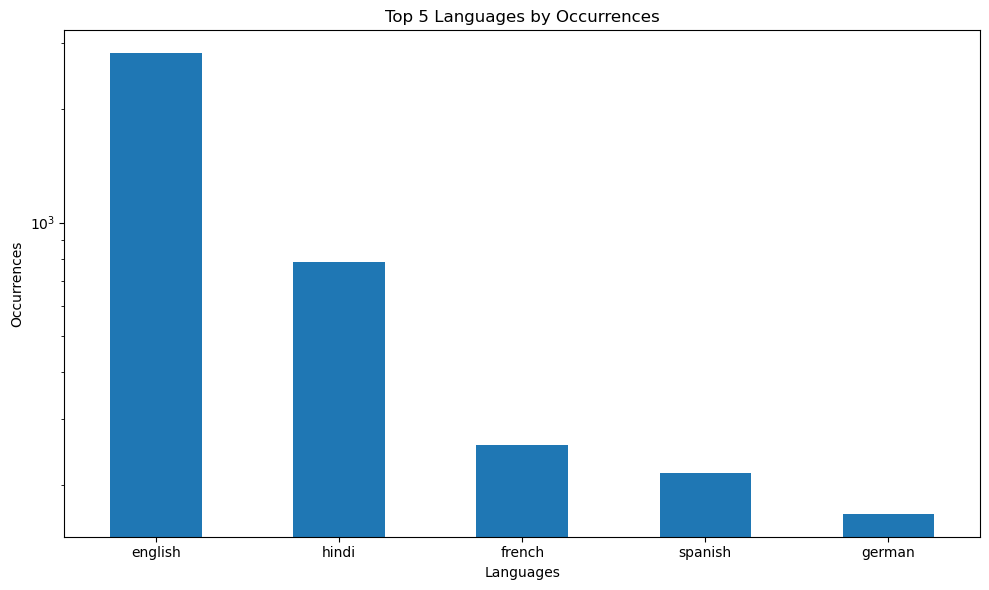

In [21]:
eda_streaming.analyze_languages()

Categorizing movies into two groups: 
- those available exclusively in English, 
- those available in other languages (which may include English alongside another language).

This will be done through the creation of the boolean "Is_not_only_english" which is True when the movie is available in another language.

In [22]:
eda_streaming.categorize_languages()

There are 2036 movies that are available in other languages and 2329 movies that are only available in English.


##### 1.1.3.2 Analysis of the Movies' countries

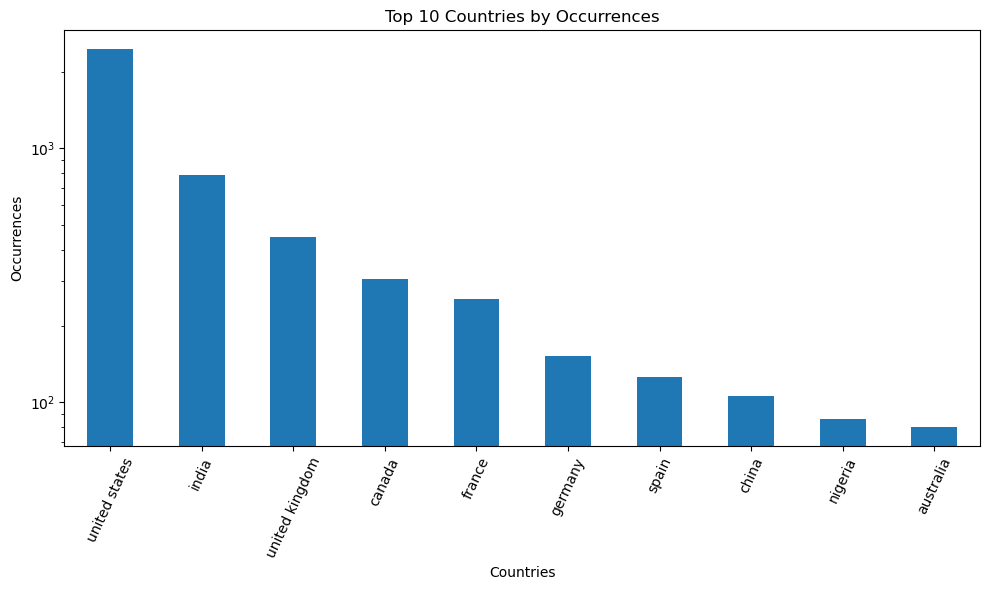

In [23]:
eda_streaming.analyze_countries()

We have a very similar situation to the languages. The United States of America have a much more prominent number of movies. We will thus proceed like previously by categorizing the movies into two groups:
- USA movies 
- Movies from other countries 

This will be done through the creation of the boolean "Is_USA_movie" which is True when the movie is from the USA.

In [24]:
count_usa_movies = (eda_streaming.dataframe["Movie_countries"] == "United States").sum()
count_other_countries_movie = len(eda_streaming.dataframe) - count_usa_movies 
print(f"There are {count_usa_movies} USA movies and {count_other_countries_movie} movies from other countries.")

There are 1686 USA movies and 2679 movies from other countries.


In [25]:
eda_streaming.categorize_countries_bis()

There are 2460 USA movies and 1905 movies from other countries.


##### 1.1.3.2 Analysis of the Movies' streaming platforms 

We created dummy variables for the streaming platforms(Netflix, Disney, Amazon prime). Each platform is now a column with 0 or 1, where 1 means the movie is available on that platform.

In [28]:
eda_streaming.dataframe = pd.get_dummies(eda_streaming.dataframe, columns=["Platform"], drop_first=True) 
eda_streaming.dataframe.sample(5)

,Show_id,Type,Movie_name,Director,Cast,Movie_countries,Date_added,Movie_release_date,Age_ratings,Movie_runtime,...,"Movie_genres_Comedy & Light-Hearted, Science Fiction & Fantasy",Movie_genres_Drama & Emotion,"Movie_genres_Drama & Emotion, Action & Adventure","Movie_genres_Drama & Emotion, Comedy & Light-Hearted","Movie_genres_Drama & Emotion, Science Fiction & Fantasy",Movie_genres_Science Fiction & Fantasy,Is_not_only_english,Is_USA_movie,Platform_Disney,Platform_Netflix
2980,s5441,Movie,Shimmer Lake,Oren Uziel,"Benjamin Walker, Rainn Wilson, Rob Corddry, Ad...","Canada, United States","June 9, 2017",2017,TV-MA,87.00,...,False,False,True,False,False,False,False,True,False,True
3411,s6145,Movie,American Honey,Andrea Arnold,"Sasha Lane, Shia LaBeouf, Riley Keough, McCaul...","United Kingdom, United States","April 27, 2019",2016,R,163.00,...,False,True,False,False,False,False,False,True,False,True
644,s1157,Movie,A Week Away,Roman White,"Kevin Quinn, Bailee Madison, Jahbril Cook, Kat...",United States,"March 26, 2021",2021,TV-PG,98.00,...,False,True,False,False,False,False,False,True,False,True
4809,s8266,Movie,The Dancer,Ifa Isfansyah,"Prisia Nasution, Oka Antara, Slamet Rahardjo, ...",Indonesia,"December 8, 2018",2011,TV-MA,105.00,...,False,True,False,False,False,False,True,False,False,True
1560,s2734,Movie,Kapoor & Sons,Shakun Batra,"Rishi Kapoor, Sidharth Malhotra, Fawad Khan, A...",India,"April 1, 2020",2016,TV-14,138.00,...,False,False,False,True,False,False,True,False,False,True


### 1.3 Linear Regression

In [30]:
streaming_df_regression = eda_streaming.dataframe.copy()

In [31]:
print(streaming_df_regression.columns)

Index(['Show_id', 'Type', 'Movie_name', 'Director', 'Cast', 'Movie_countries',
       'Date_added', 'Movie_release_date', 'Age_ratings', 'Movie_runtime',
       'Description', 'Male_actors', 'Female_actors', 'Average_ratings',
       'Num_votes', 'Is_Adult', 'Movie_languages', 'log_Num_votes',
       'log_Movie_runtime', 'log_Female_actors', 'log_Male_actors',
       'Movie_genres_Action & Adventure, Science Fiction & Fantasy',
       'Movie_genres_Comedy & Light-Hearted',
       'Movie_genres_Comedy & Light-Hearted, Action & Adventure',
       'Movie_genres_Comedy & Light-Hearted, Science Fiction & Fantasy',
       'Movie_genres_Drama & Emotion',
       'Movie_genres_Drama & Emotion, Action & Adventure',
       'Movie_genres_Drama & Emotion, Comedy & Light-Hearted',
       'Movie_genres_Drama & Emotion, Science Fiction & Fantasy',
       'Movie_genres_Science Fiction & Fantasy', 'Is_not_only_english',
       'Is_USA_movie', 'Platform_Disney', 'Platform_Netflix'],
      dtype='object')

In [44]:
indep_vars=["log_Female_actors", "log_Male_actors", "Num_votes", "log_Movie_runtime", "Is_not_only_english", "Is_USA_movie",
            'Movie_genres_Action & Adventure, Science Fiction & Fantasy',
       'Movie_genres_Comedy & Light-Hearted',
       'Movie_genres_Comedy & Light-Hearted, Action & Adventure',
       'Movie_genres_Comedy & Light-Hearted, Science Fiction & Fantasy',
       'Movie_genres_Drama & Emotion',
       'Movie_genres_Drama & Emotion, Action & Adventure',
       'Movie_genres_Drama & Emotion, Comedy & Light-Hearted',
       'Movie_genres_Drama & Emotion, Science Fiction & Fantasy',
       'Movie_genres_Science Fiction & Fantasy', 'Platform_Disney', 'Platform_Netflix', "Is_Adult"]

dep_vars = "Average_ratings"

X = streaming_df_regression[indep_vars]
y = streaming_df_regression[dep_vars]

scaler = StandardScaler()
X_scaled_streaming = scaler.fit_transform(X)

X_scaled_streaming = pd.DataFrame(X_scaled_streaming, columns=X.columns, index=X.index)

X_scaled_wconst_streaming = sm.add_constant(X_scaled_streaming)

In [45]:
# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled_streaming.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled_streaming.values, i) for i in range(X_scaled_streaming.shape[1])]

# Display VIF values
print(vif_data)

                                              Feature  VIF
0                                   log_Female_actors 1.20
1                                     log_Male_actors 1.22
2                                           Num_votes 1.14
3                                   log_Movie_runtime 1.33
4                                 Is_not_only_english 1.99
5                                        Is_USA_movie 2.16
6   Movie_genres_Action & Adventure, Science Ficti... 1.73
7                 Movie_genres_Comedy & Light-Hearted 2.02
8   Movie_genres_Comedy & Light-Hearted, Action & ... 1.41
9   Movie_genres_Comedy & Light-Hearted, Science F... 1.18
10                       Movie_genres_Drama & Emotion 2.75
11   Movie_genres_Drama & Emotion, Action & Adventure 1.83
12  Movie_genres_Drama & Emotion, Comedy & Light-H... 2.19
13  Movie_genres_Drama & Emotion, Science Fiction ... 1.13
14             Movie_genres_Science Fiction & Fantasy 1.40
15                                    Platform_Disney 2.

In [46]:
model_streaming = sm.OLS(y, X_scaled_wconst_streaming).fit()
print(model_streaming.summary())

                            OLS Regression Results                            
Dep. Variable:        Average_ratings   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     51.70
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          9.45e-168
Time:                        22:07:09   Log-Likelihood:                -6200.7
No. Observations:                4365   AIC:                         1.244e+04
Df Residuals:                    4346   BIC:                         1.256e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

### 5. <u>What are the social reasons behind the presence of female characters in movies? Is it due to sexualization or genuine equality of representation?</u>

The first part of our analysis uses plot summaries to examine whether female characters are portrayed as having agency (taking action and driving the story) or are reduced to sexualized or objectified roles. So far, we have used LLMs, such as ChatGPT Plus, to classify plot summaries based on these criteria (contains/does not contain sexualization of females), which provided useful initial results and validated the approach. However, due to time constraints during milestone 2, we were unable to use more advanced methods, such as zero-shot or few-shot learning with models like OpenAI's GPT-4, T5, or BERT variants, which we plan to explore further in milestone 3.
The second part of our analysis focuses on adult-rated films in the resulting merged dataframe, specifically examining the gender of the actors to understand patterns of representation.

In [ ]:
bechdel_df = pd.read_csv("data/Bechdel test/bechdel_test_movies.csv", names=["Id", "Year", "Title", "Bechdel_rating", "tconst"], header=None)

bechdel_df = bechdel_df.drop(index=0)
bechdel_df.head()

,Id,Year,Title,Bechdel_rating,tconst
1,9602,1874,Passage de Venus,0,3155794
2,9804,1877,La Rosace Magique,0,14495706
3,9603,1878,Sallie Gardner at a Gallop,0,2221420
4,9806,1878,Le singe musicien,0,12592084
5,9816,1881,Athlete Swinging a Pick,0,7816420


In [ ]:
bechdel_df["tconst"] = bechdel_df["tconst"].apply(lambda x : "tt"+str(x))
bechdel_df.head()

,Id,Year,Title,Bechdel_rating,tconst
1,9602,1874,Passage de Venus,0,tt3155794
2,9804,1877,La Rosace Magique,0,tt14495706
3,9603,1878,Sallie Gardner at a Gallop,0,tt2221420
4,9806,1878,Le singe musicien,0,tt12592084
5,9816,1881,Athlete Swinging a Pick,0,tt7816420


In [ ]:
final_final_df = pd.merge(eda.dataframe.copy(), bechdel_df, on="tconst")
len(final_final_df)

1934

In [ ]:
final_final_df.drop(columns=["tconst"])
final_final_df["Bechdel_rating"].value_counts()

Bechdel_rating
3    1044
1     542
2     220
0     128
Name: count, dtype: int64

In [ ]:
final_final_df["Bechdel_rating"] = pd.to_numeric(final_final_df["Bechdel_rating"])

In [ ]:
indep_cols = ["log_Female_actors", "log_Male_actors", "log_Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie", "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_romance_film", "Start_year",
                   "Box_office_companies", "Bechdel_rating", "log_Num_votes"]

X = final_final_df[indep_cols]

y = final_final_df["Log_ROI"]

In [ ]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled_wconst = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled_wconst).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Log_ROI   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     43.27
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           1.99e-97
Time:                        10:37:53   Log-Likelihood:                 3135.5
No. Observations:                1934   AIC:                            -6243.
Df Residuals:                    1920   BIC:                            -6165.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# Display VIF values
print(vif_data)

                    Feature  VIF
0         log_Female_actors 1.32
1           log_Male_actors 1.30
2         log_Movie_runtime 1.32
3       Is_not_only_english 1.08
4              Is_USA_movie 1.08
5          Main_genre_drama 2.47
6       Main_genre_thriller 2.45
7         Main_genre_comedy 1.86
8   Main_genre_romance_film 1.62
9                Start_year 1.09
10     Box_office_companies 1.10
11           Bechdel_rating 1.29
12            log_Num_votes 1.37


In [ ]:
indep_cols = ["log_Female_actors", "log_Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie", "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_romance_film", "Start_year",
                   "Box_office_companies", "Bechdel_rating", "Log_ROI"]

X = final_final_df[indep_cols]

y = final_final_df["Normalized_Rating"]

In [ ]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled_wconst = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled_wconst).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Normalized_Rating   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     50.51
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.14e-112
Time:                        10:37:53   Log-Likelihood:                 2289.7
No. Observations:                1934   AIC:                            -4551.
Df Residuals:                    1920   BIC:                            -4474.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# Display VIF values
print(vif_data)

                    Feature  VIF
0         log_Female_actors 1.32
1           log_Male_actors 1.25
2             Movie_runtime 1.24
3       Is_not_only_english 1.07
4              Is_USA_movie 1.07
5          Main_genre_drama 2.38
6       Main_genre_thriller 2.45
7         Main_genre_comedy 1.84
8   Main_genre_romance_film 1.60
9                Start_year 1.04
10     Box_office_companies 1.08
11           Bechdel_rating 1.29
12                  Log_ROI 1.04


In [ ]:
indep_cols = ["log_Female_actors", "log_Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie", "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_romance_film", "Start_year",
                   "Box_office_companies", "Log_ROI"]

X = final_final_df[indep_cols]

y = final_final_df["Bechdel_rating"]

In [ ]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled_wconst = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled_wconst).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Bechdel_rating   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     45.86
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           3.27e-96
Time:                        10:37:54   Log-Likelihood:                -2564.8
No. Observations:                1934   AIC:                             5156.
Df Residuals:                    1921   BIC:                             5228.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# Display VIF values
print(vif_data)

                    Feature  VIF
0         log_Female_actors 1.10
1           log_Male_actors 1.19
2             Movie_runtime 1.24
3       Is_not_only_english 1.07
4              Is_USA_movie 1.07
5          Main_genre_drama 2.38
6       Main_genre_thriller 2.44
7         Main_genre_comedy 1.84
8   Main_genre_romance_film 1.60
9                Start_year 1.04
10     Box_office_companies 1.08
11                  Log_ROI 1.03


## New Dialogue dataset

In [44]:
movie_dialogue_df = pd.read_csv("data/Dialogue/meta_data7.csv",names=["Script_id", "tconst", "Title", "Year", "Gross", "Lines_Data"], header=0, encoding="ISO-8859-1")
movie_dialogue_df.drop(columns=["Gross", "Lines_Data"], inplace=True)
movie_dialogue_df.head()

,Script_id,tconst,Title,Year
0,1534,tt1022603,(500) Days of Summer,2009
1,1512,tt0147800,10 Things I Hate About You,1999
2,1514,tt0417385,12 and Holding,2005
3,1517,tt2024544,12 Years a Slave,2013
4,1520,tt1542344,127 Hours,2010


In [45]:
character_dialogue_df = pd.read_csv("data/Dialogue/character_list5.csv",names=["Script_id", "Character_name", "Words", "Gender", "Age"], header=0, encoding="ISO-8859-1")
character_dialogue_df.dropna(subset=["Character_name", "Age"], inplace=True)
character_dialogue_df.head()

,Script_id,Character_name,Words,Gender,Age
0,280,betty,311,f,35.0
3,280,francesca johns,2251,f,46.0
4,280,madge,190,f,46.0
5,280,michael johnson,723,m,38.0
6,280,robert kincaid,1908,m,65.0


In [ ]:
'''# Create columns for male, female character counts
character_counts = character_dialogue_df.groupby("Script_id")["Gender"].value_counts().unstack(fill_value=0)
character_counts = character_counts.rename(columns={"m": "Male_characters", "f": "Female_characters"})
character_counts = character_counts.reset_index()

movie_dialogue_df = movie_dialogue_df.merge(character_counts, on="Script_id", how="left")
movie_dialogue_df.head()'''

In [46]:
dialogue_df = pd.merge(movie_dialogue_df, character_dialogue_df, on="Script_id")
dialogue_df.drop(columns=["Script_id"], inplace = True)
dialogue_df.head()

,tconst,Title,Year,Character_name,Words,Gender,Age
0,tt1022603,(500) Days of Summer,2009,alison,316,f,27.0
1,tt1022603,(500) Days of Summer,2009,autumn - girl a,402,f,29.0
2,tt1022603,(500) Days of Summer,2009,douche,134,m,32.0
3,tt1022603,(500) Days of Summer,2009,mckenzie,1152,m,31.0
4,tt1022603,(500) Days of Summer,2009,narrator,684,m,63.0


In [47]:
final_dialogue_df = dialogue_df.groupby("tconst").agg(
    Characters=("Character_name", list),
    Words=("Words", list),
    Gender=("Gender", list)
)
final_dialogue_df.head()

,Characters,Words,Gender
tconst,,,
tt0019777,"[bob, chico, hammer, mrs. potter, penelope, po...","[668, 915, 5577, 492, 534, 386]","[m, m, m, f, f, f]"
tt0021884,"[baron frankenst, doctor waldman, elizabeth, h...","[390, 844, 425, 1282, 858]","[m, m, f, m, m]"
tt0022054,"[bill talbot, cary lockwood, francis, frink, m...","[1156, 2527, 230, 364, 237, 1912, 1376]","[m, m, m, m, m, f, m]"
tt0022626,"[ames, charlie, clark, cluett, dickson, dude f...","[228, 408, 1892, 2264, 7262, 344, 824, 1758, 2...","[m, m, m, m, m, m, f, m, m, m, m, m, f, f, m, ..."
tt0022958,"[chauffeur, clerk (u, doctor otternsc, ...","[400, 302, 1044, 270, 2332, 4964, 1080, 4710, ...","[m, m, m, m, f, m, m, f, m, m, m, m, m, m, f, ..."


In [48]:
dialogue_merged_df = pd.merge(final_df, final_dialogue_df, on="tconst")
len(dialogue_merged_df)

1639